# Experiments with CIFAR100 Dataset and Original MoE

The experiments in this notebook include training the original MoE models as follows:

1. original MoE without regularization.
2. original MoE with $L_{importance}$ regularization.
3. original MoE with $L_s$ regularization.
4. train a single model.

In [1]:
import sys
sys.path.append('../src/cifar100')
sys.path.append('../src')

In [2]:
from cifar100_original_moe_training import *
from original_moe_training import *
from single_model_training import *

/nobackup/projects/bdrap03/yamuna/miniconda/envs/mnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified
device cuda:0
device cuda:0


## Load CIFAR10 dataset

In [3]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/cifar100'
model_path = '../models/cifar100'
results_path = '../results/cifar100'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)    

In [4]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18)):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = images_to_plot.shape[0]
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    
    for i in range(n_images):
        img = images_to_plot[i,:,:,:]
        npimg = np.clip(img.numpy(),0,1)
        ax[i].imshow(npimg)
        ax[i].axis('off')  
        if titles is not None and i<10:
            ax[i].set_title(titles[i%10])

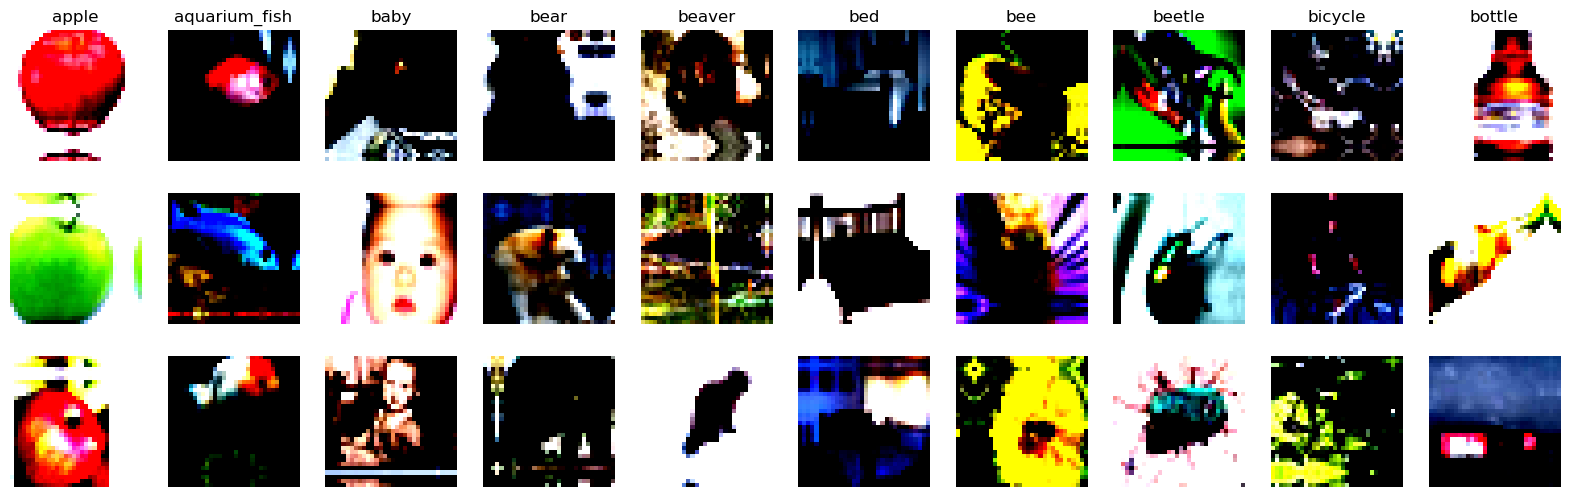

In [5]:
# get some random training images
dataiter = iter(cifar100_trainloader)
images, labels = dataiter.next()

images_to_plot = []
count = 0
selected_labels = []
for i in range(100):
    if count == 10:
        break
    index = np.where(labels==i)[0]
    if len(index) >= 3:
        selected_labels.append(i)
        images_to_plot.append(images[index[0:3],:,:])
        count += 1
    
selected_labels = [classes_cifar100[i] for i in selected_labels]
images_to_plot = torch.transpose(torch.stack(images_to_plot),0,1)
new_shape = images_to_plot.shape
images_to_plot = images_to_plot.reshape(new_shape[0]*new_shape[1], new_shape[2], new_shape[3], new_shape[4])
images_to_plot = images_to_plot.permute(0,2,3,1)
plot_colour_images(images_to_plot, nrows=3, ncols=10,thefigsize=(20,6), titles=selected_labels)

## Define expert and gate networks

In [6]:
# # Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
# class expert_layers(nn.Module):
#     def __init__(self, num_classes, channels=3):
#         super(expert_layers, self).__init__()
#         filter_size = 3
#         self.filters = 8
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(self.filters*2)
#         self.mp = nn.MaxPool2d(2,2)

#         self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
#         self.bn4 = nn.BatchNorm2d(self.filters*4)

#         self.conv5 = nn.Conv2d(in_channels= self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=self.filters*8, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
#         self.bn8 = nn.BatchNorm2d(self.filters*8)

#         self.fc1 = nn.Linear(self.filters*8*2*2,512)
#         self.fc2 = nn.Linear(512, 128)
        
#         self.out = nn.Linear(in_features=128, out_features=num_classes)
                        
#     def forward(self, t):
#         # conv 1        
#         x = F.relu(self.conv1(t))
#         x = self.mp(F.relu(self.conv2(x)))
                
#         x = self.mp(F.relu(self.bn4(self.conv3(x))))
        
#         x = F.relu(self.conv4(x))
#         x = self.mp(F.relu(self.conv5(x)))
        
#         x = self.mp(F.relu(self.bn8(self.conv6(x))))       
                    
#         x = x.reshape(-1, self.filters*8*2*2)
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        
#         x = self.out(x)
        
#         # output
#         x = F.softmax(x, dim=1)
        
#         return x

In [7]:
# # Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
# class gate_layers(nn.Module):
#     def __init__(self, num_experts):
#         super(gate_layers, self).__init__()
#         # define layers
#         filter_size = 3
#         self.filters = 64
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(self.filters*2)
#         self.mp = nn.MaxPool2d(2,2)

#         self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
#         self.bn4 = nn.BatchNorm2d(self.filters*4)

#         self.conv5 = nn.Conv2d(in_channels= self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=self.filters*8, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
#         self.bn8 = nn.BatchNorm2d(self.filters*8)

#         self.fc1 = nn.Linear(self.filters*8*2*2,1024)
#         self.fc2 = nn.Linear(1024, 128)
        
#         self.out = nn.Linear(in_features=128, out_features=num_experts)
                        
#     def forward(self,t , T=1.0, y=None):
#         # conv 1        
#         x = F.relu(self.conv1(t))
#         x = self.mp(F.relu(self.conv2(x)))
                
#         x = self.mp(F.relu(self.bn4(self.conv3(x))))
        
#         x = F.relu(self.conv4(x))
#         x = self.mp(F.relu(self.conv5(x)))
        
#         x = self.mp(F.relu(self.bn8(self.conv6(x))))       
                    
#         x = x.reshape(-1, self.filters*8*2*2)
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        
#         x = self.out(x)
        
#         # print('G', x.shape)
        
#         # output
#         x = F.softmax(x/T, dim=1)        
#         return x


In [8]:
# import torchvision.models as models
# class expert_layers(nn.Module):
#     def __init__(self, num_classes, channels=3):
#         super(expert_layers, self).__init__()
#         self.resnet18 = models.resnet18(pretrained=True)
#         self.resnet18.fc = nn.Linear(512, num_classes)
#     def forward(self, x, T=1.0, y=None):
#         x = self.resnet18(x) 
#         x = F.softmax(x, dim=1)
#         # print(x.shape, x[0])
#         return x
        

In [9]:
# class gate_layers(nn.Module):
#     def __init__(self, num_experts, channels=3):
#         super(gate_layers, self).__init__()
#         # define layers
#         filter_size = 3
#         self.filters = 64
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(self.filters*2)
#         self.mp = nn.MaxPool2d(2,2)
        
#         self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
#         self.bn4 = nn.BatchNorm2d(self.filters*4)

#         self.fc1 = nn.Linear(self.filters*4*4*4, 512)
#         self.fc2 = nn.Linear(512, 32)
        
#         self.out = nn.Linear(in_features=32, out_features=num_experts)
        
#     def forward(self, x, T=1.0, y=None):
#         # conv 1        
        
#         x = F.relu(self.conv1(x))
#         x = self.mp(F.relu(self.conv2(x)))  

#         x = self.mp(F.relu(self.bn4(self.conv3(x))))
#         x =  self.mp(F.relu(self.conv4(x)))
#         # print('gate', x.shape)
#         x = x.reshape(-1, self.filters*4*4*4)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        
#         x = self.out(x)
#         x = F.softmax(x/T, dim=1)
        
#         return x
    

In [10]:
import torchvision.models as models
class single_model(nn.Module):
    def __init__(self, num_classes, channels=3):
        super(single_model, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(512, num_classes)
    def forward(self, x, T=1.0, y=None):
        x = self.resnet18(x) 
        x = F.softmax(x, dim=1)
        # print(x.shape, x[0])
        return x
        

In [11]:
# # Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
# class single_model(nn.Module):
#     def __init__(self, num_classes, channels=3):
#         super(single_model, self).__init__()
#         filter_size = 3
#         self.filters = 8
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(self.filters*2)
#         self.mp = nn.MaxPool2d(2,2)

#         self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
#         self.bn4 = nn.BatchNorm2d(self.filters*4)

#         self.conv5 = nn.Conv2d(in_channels= self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=self.filters*8, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
#         self.bn8 = nn.BatchNorm2d(self.filters*8)

#         self.fc1 = nn.Linear(self.filters*8*2*2,512)
#         self.fc2 = nn.Linear(512, 128)
        
#         self.out = nn.Linear(in_features=128, out_features=num_classes)
                        
#     def forward(self, t):
#         # conv 1        
#         x = F.relu(self.conv1(t))
#         x = self.mp(F.relu(self.conv2(x)))
                
#         x = self.mp(F.relu(self.bn4(self.conv3(x))))
        
#         x = F.relu(self.conv4(x))
#         x = self.mp(F.relu(self.conv5(x)))
        
#         x = self.mp(F.relu(self.bn8(self.conv6(x))))
                            
#         x = x.reshape(-1, self.filters*8*2*2)
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        
#         x = self.out(x)
        
#         # output
#         x = F.softmax(x, dim=1)
                
#         return x

## Initialize configurations and helper functions

In [12]:
# import sys
# sys.path.append('../../WideResNet-pytorch-master')

In [13]:
# from wideresnet import WideResNet

In [14]:
# number_of_layers = 40
# model = WideResNet(depth=number_of_layers, num_classes=100, widen_factor=4)
# checkpoint = torch.load('../../WideResNet-pytorch-master/runs/WideResNet-28-10/cifar100.pth.tar')
# model.load_state_dict(checkpoint['state_dict'])
# model = model.to(device)
# model.eval()

## Experiments

In [21]:
# Model with gate and expert parameters initialized to default values
model_3 = 'cifar100_re_sample_sim'

In [22]:
total_experts = 20

In [23]:
num_epochs = 200

In [24]:
w_sample_sim_same_range = [0.0] #[1e-4]
w_sample_sim_diff_range = [0.0] #[1e-4]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [0.0]
w_sample_sim_diff_range =  [0.0]


In [29]:
runs = 1

In [49]:
distance_funct = resnet_distance_funct(model).distance_funct
train_original_model(model=model_3, model_name='moe_expectation_model', k=0,
                     trainloader=cifar100_trainloader, testloader=cifar100_testloader, 
                     expert_layers=expert_layers, gate_layers=gate_layers,
                     w_sample_sim_same_range=w_sample_sim_same_range, 
                     w_sample_sim_diff_range=w_sample_sim_diff_range, distance_funct= distance_funct,                    
                     temps=[[1.0]*num_epochs],runs=runs, num_classes=num_classes, total_experts=total_experts, 
                     num_epochs=num_epochs, model_path=model_path)

NameError: name 'model' is not defined

### Experiment 1: Original MoE model trained without gate regularization

In [24]:
# Model with gate and expert parameters initialized to default values
model_1 = 'cifar100_expectation'

In [25]:
total_experts = 10

In [27]:
num_epochs = 100

In [28]:
runs = 1

In [29]:
temps = [[1.0]*num_epochs]

In [ ]:
train_original_model(model=model_1, model_name='moe_expectation_model', k=0,
                     trainloader=cifar100_trainloader, testloader=cifar100_testloader, 
                     expert_layers=expert_layers, gate_layers=gate_layers,             
                     temps=[[1.0]*num_epochs],runs=runs, num_classes=num_classes, total_experts=total_experts, 
                     num_epochs=num_epochs,lr=0.001, model_path=model_path)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 4.56 , training accuracy 0.06 , test accuracy 0.05
epoch 1 training loss 4.56 , training accuracy 0.05 , test accuracy 0.06
epoch 2 training loss 4.56 , training accuracy 0.05 , test accuracy 0.04
epoch 3 training loss 4.56 , training accuracy 0.06 , test accuracy 0.05
epoch 4 training loss 4.55 , training accuracy 0.06 , test accuracy 0.06
epoch 5 training loss 4.55 , training accuracy 0.07 , test accuracy 0.08
epoch 6 training loss 4.54 , training accuracy 0.08 , test accuracy 0.08
epoch 7 training loss 4.54 , training accuracy 0.08 , test accuracy 0.08
epoch 8 training loss 4.54 , training accuracy 0.08 , test accuracy 0.09
epoch 9 training loss 4.54 , training accuracy 0.09 , test accuracy 0.09
epoch 10 training loss 4.53 , training accuracy 0.09 , test accuracy 0.09
epoch 11 training loss 4.53 , training accuracy 0.09 , test accuracy 0.09
epoch 12 training loss 4.53 , training accuracy 0.09 ,

In [17]:
model_1 = 'cifar100_stochastic_test'
train_original_model(model_1, 'moe_stochastic_model', k=0,
                     trainloader=cifar100_trainloader, testloader=cifar100_testloader, 
                     expert_layers=expert_layers, gate_layers=gate_layers,
                     runs=runs, temps=temps,
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs, lr=0.0001,
                     model_path=model_path)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.72 , training accuracy 0.24 , test accuracy 0.35
epoch 1 training loss 1.17 , training accuracy 0.45 , test accuracy 0.43
epoch 2 training loss 0.98 , training accuracy 0.53 , test accuracy 0.46
epoch 3 training loss 0.86 , training accuracy 0.59 , test accuracy 0.48
epoch 4 training loss 0.76 , training accuracy 0.64 , test accuracy 0.50
epoch 5 training loss 0.69 , training accuracy 0.68 , test accuracy 0.51
epoch 6 training loss 0.63 , training accuracy 0.71 , test accuracy 0.52
epoch 7 training loss 0.58 , training accuracy 0.74 , test accuracy 0.52
epoch 8 training loss 0.53 , training accuracy 0.77 , test accuracy 0.52
epoch 9 training loss 0.49 , training accuracy 0.79 , test accuracy 0.53
epoch 10 training loss 0.45 , training accuracy 0.82 , test accuracy 0.52
epoch 11 training loss 0.42 , training accuracy 0.83 , test accuracy 0.53
epoch 12 training loss 0.38 , training accuracy 0.85 ,

### Experiment 2: Original MoE model trained with $L_{importance}$ regularization

In [ ]:
# Model with gate and expert parameters initialized to default values
model_2 = 'cifar_with_reg'

In [ ]:
total_experts = 20

In [ ]:
num_epochs = 20

In [ ]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range = [0.6]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

In [ ]:
temps = [[1]*num_epochs]

In [ ]:
runs = 1

In [ ]:
train_original_model(model_2, cifar100_trainloader, cifar100_testloader, runs, temps=temps,
                     w_importance_range=w_importance_range, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

### Experiment 3: Original MoE model trained with sample similarity regularization, $L_s$

In [ ]:
model_3 = 'cifar_with_reg'

In [ ]:
total_experts = 20

In [ ]:
num_epochs = 40

In [ ]:
temps = [[1]*num_epochs]

In [ ]:
w_sample_sim_same_range = [1e-4]
w_sample_sim_diff_range = [1e-7]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

In [ ]:
runs = 1

In [ ]:
train_original_model(model_3, cifar100_trainloader, cifar100_testloader, runs, temps=temps,
                                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

### Experiment 4: Training the single model

In [18]:
model_4 = 'cifar100_single_model_test'

In [19]:
num_epochs = 200

In [20]:
runs = 1

In [21]:
train_single_model(model_4, single_model, cifar100_trainloader, cifar100_testloader, 
                   num_classes, num_epochs, runs,model_path=model_path)

Run 1
epoch 0 training loss 3.59 , training accuracy 0.22 , test accuracy 0.33
epoch 1 training loss 2.40 , training accuracy 0.41 , test accuracy 0.43
epoch 2 training loss 2.03 , training accuracy 0.48 , test accuracy 0.46
epoch 3 training loss 1.80 , training accuracy 0.54 , test accuracy 0.50
epoch 4 training loss 1.64 , training accuracy 0.57 , test accuracy 0.52
epoch 5 training loss 1.50 , training accuracy 0.61 , test accuracy 0.53
epoch 6 training loss 1.40 , training accuracy 0.64 , test accuracy 0.53
epoch 7 training loss 1.30 , training accuracy 0.66 , test accuracy 0.55
epoch 8 training loss 1.21 , training accuracy 0.69 , test accuracy 0.55
epoch 9 training loss 1.14 , training accuracy 0.71 , test accuracy 0.55
epoch 10 training loss 1.06 , training accuracy 0.73 , test accuracy 0.55
epoch 11 training loss 0.99 , training accuracy 0.75 , test accuracy 0.56
epoch 12 training loss 0.93 , training accuracy 0.77 , test accuracy 0.56
epoch 13 training loss 0.87 , training acc

KeyboardInterrupt: 

## Results

### Collect the train error, test error for the trained single models and store in the '../results/cifar_results.csv' file.

Num  models 2
cifar100_with_attn_stochastic_rand_init_100_20_models.pt


<Figure size 640x480 with 0 Axes>

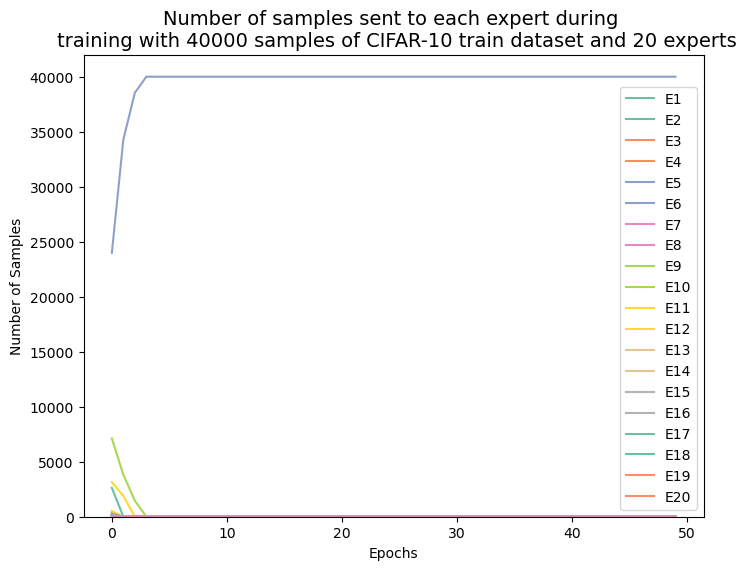

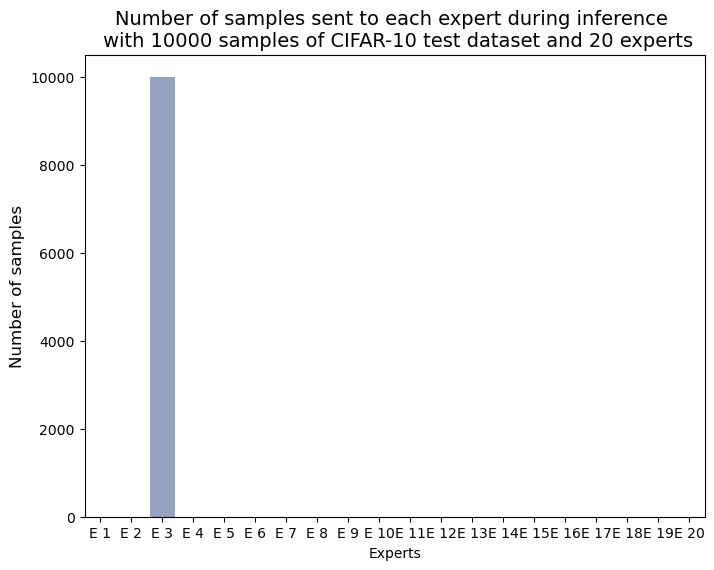

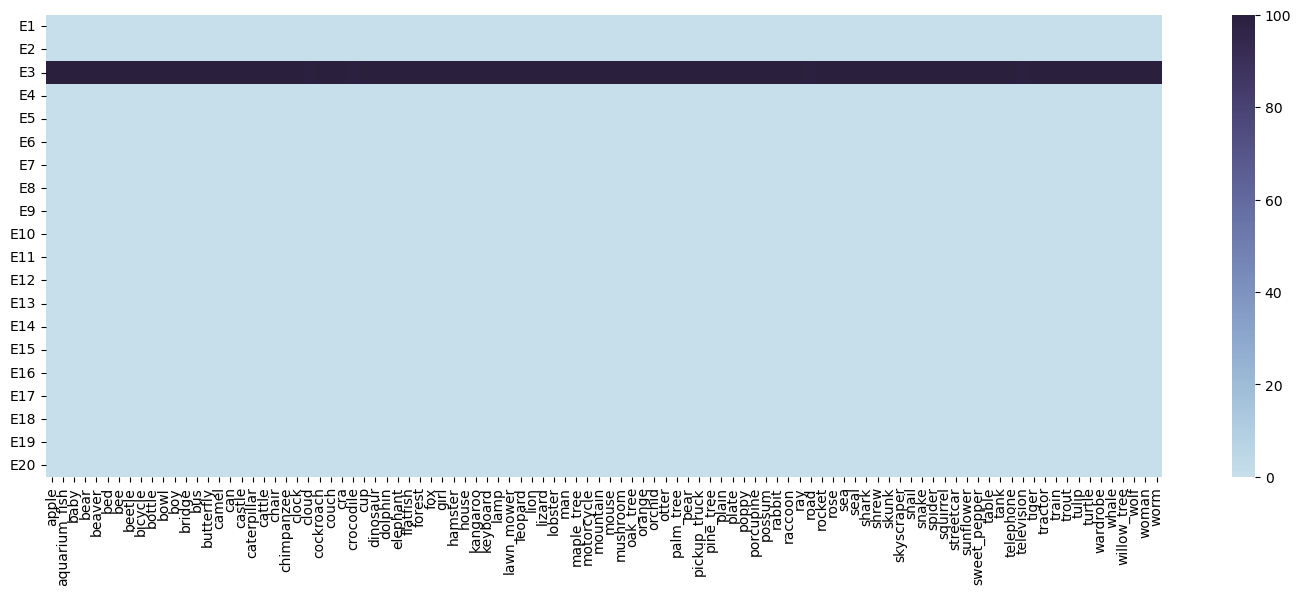

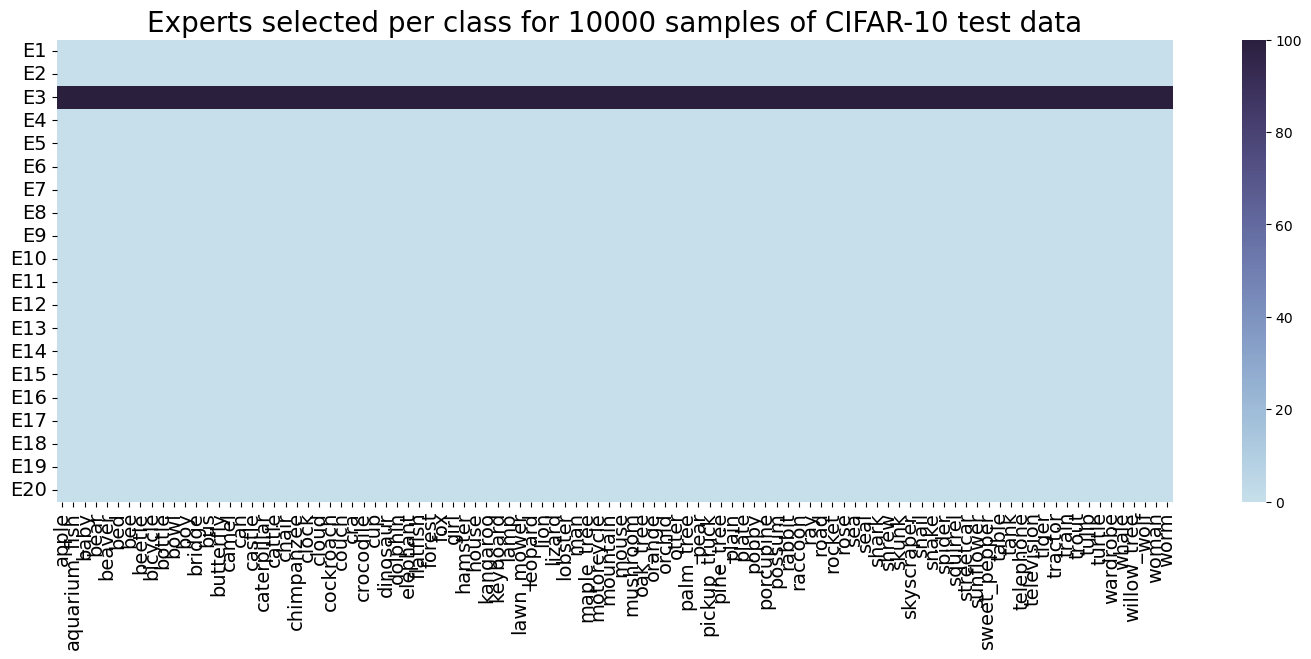

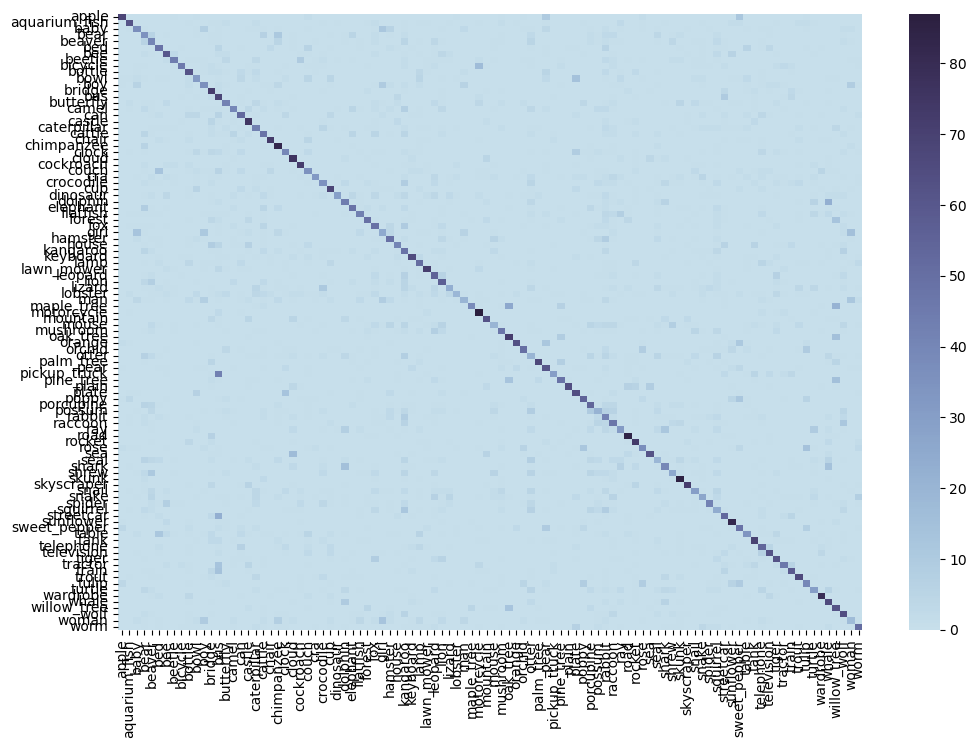

In [26]:
m = 'cifar100_with_attn_stochastic_rand_init'
total_experts = 20
classes = classes_cifar100
num_epochs = 50
temps = [[1.0]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, 'moe_stochastic_model', test_loader=test_loader, temps=temps,
                  w_importance_range=w_importance_range, 
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, 
                  dataset='CIFAR-10', best=False, index=-1, annot=False, device=device)

Num  models 2
cifar100_with_attn_rand_init_top_2_100_20_models.pt


<Figure size 640x480 with 0 Axes>

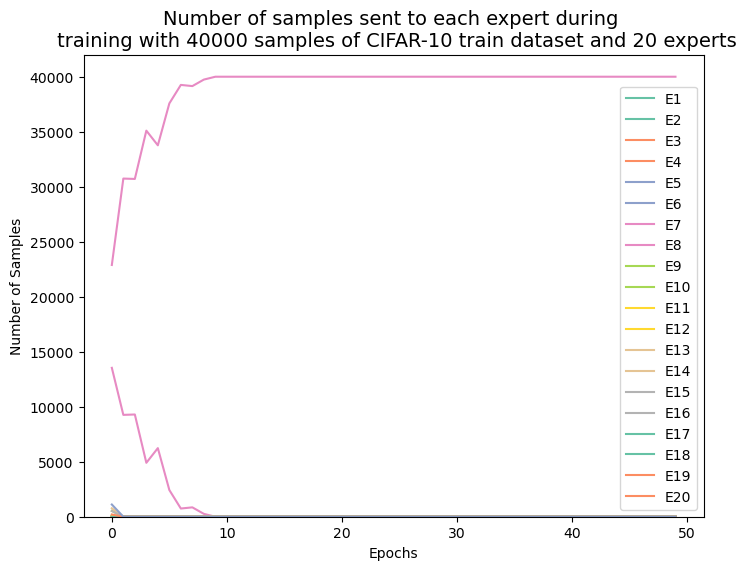

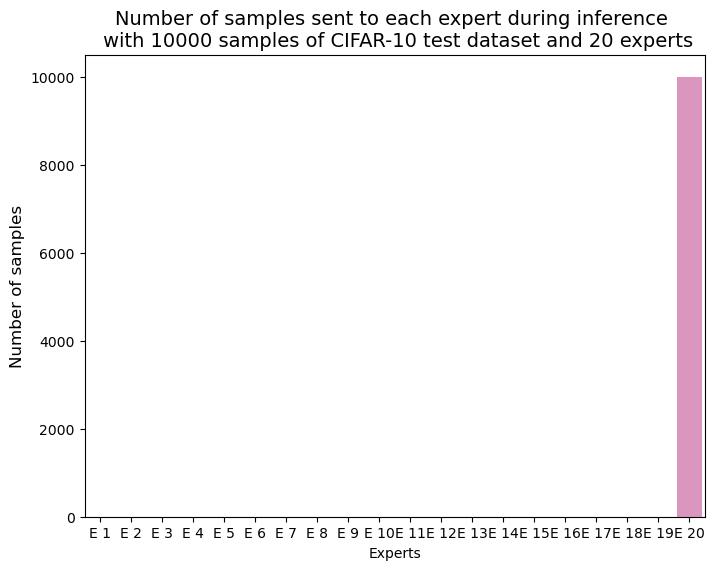

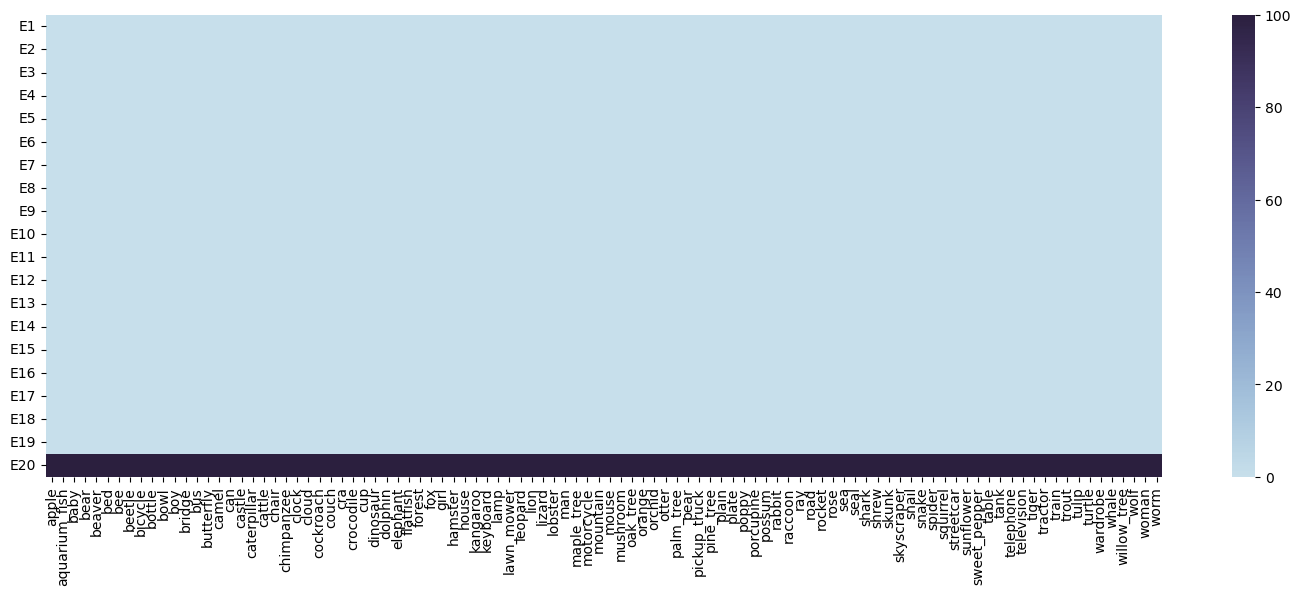

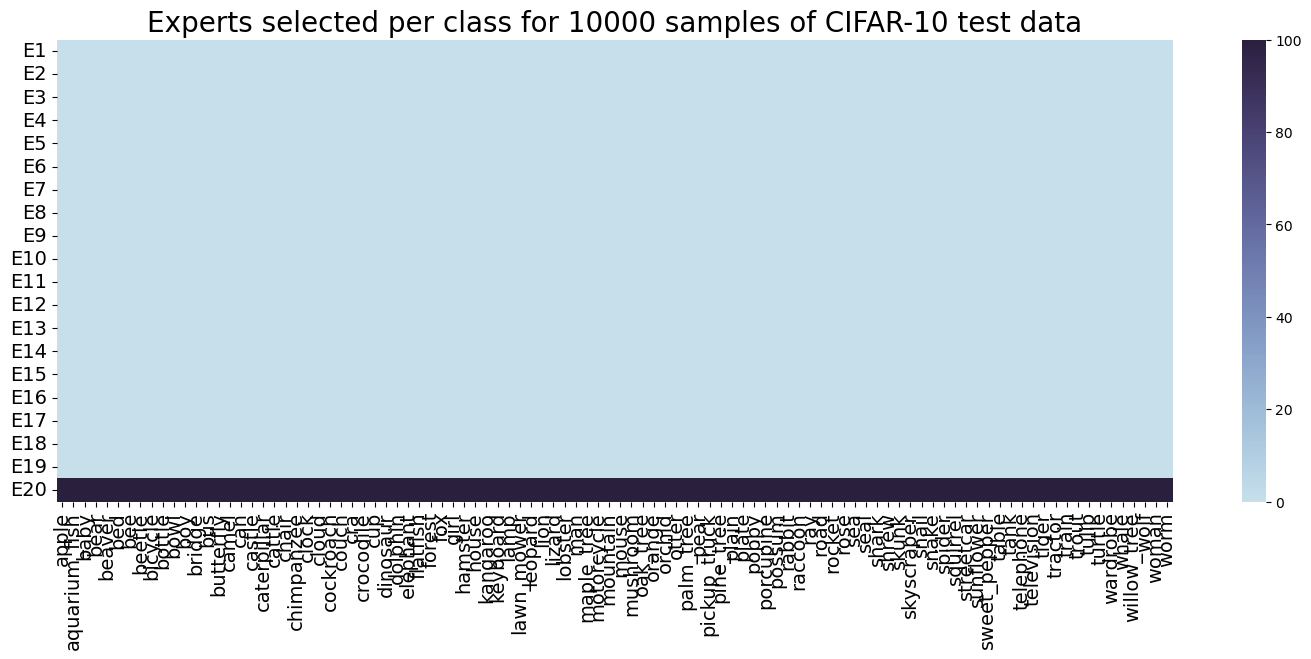

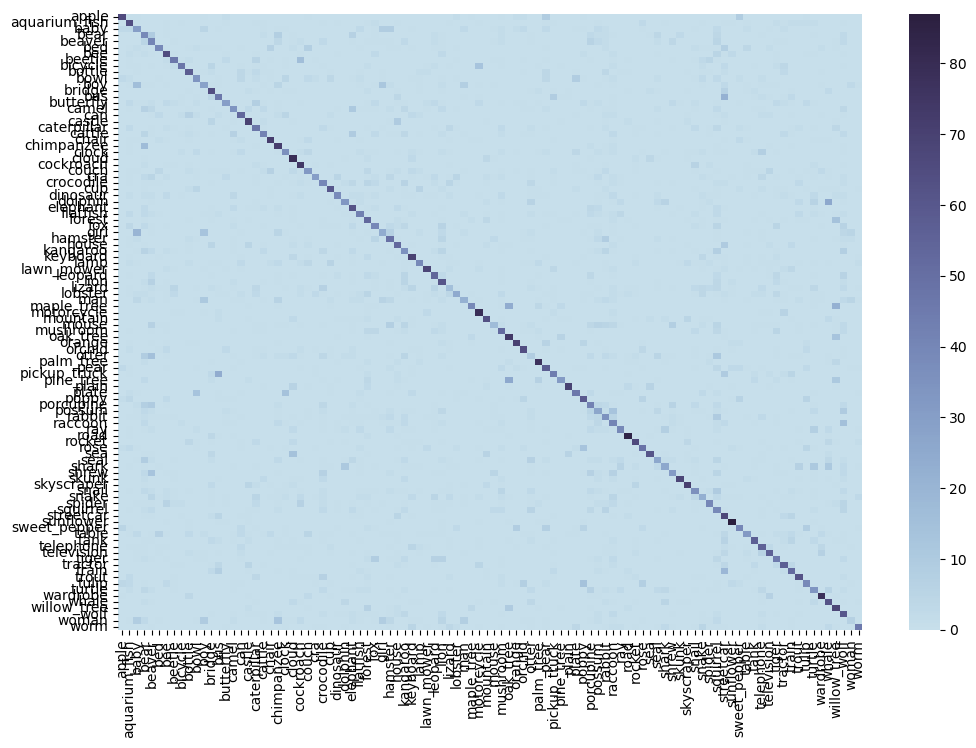

In [24]:
m = 'cifar100_with_attn_rand_init_top_2'
total_experts = 20
classes = classes_cifar100
num_epochs = 50
temps = [[1.0]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, 'moe_top_k_model', test_loader=test_loader, temps=temps,
                  w_importance_range=w_importance_range, 
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, 
                  dataset='CIFAR-10', best=False, index=-1, annot=False, device=device)

Num  models 2
cifar100_rand_init_top_2_100_20_models.pt


<Figure size 640x480 with 0 Axes>

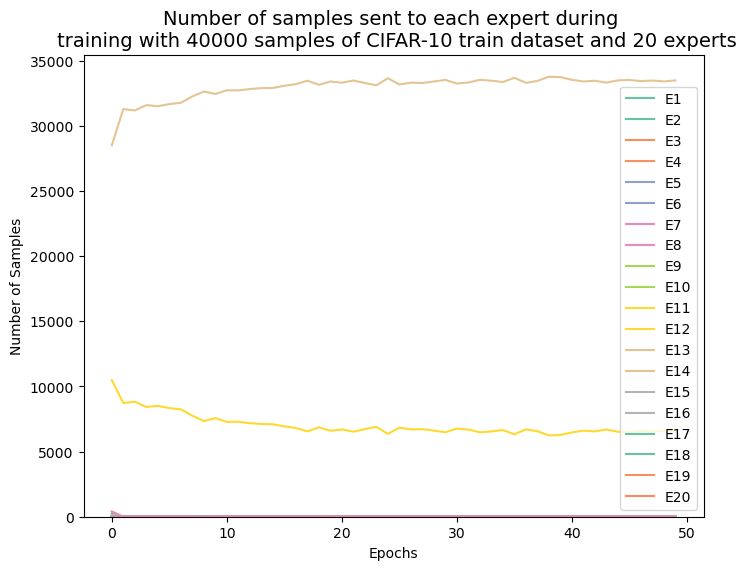

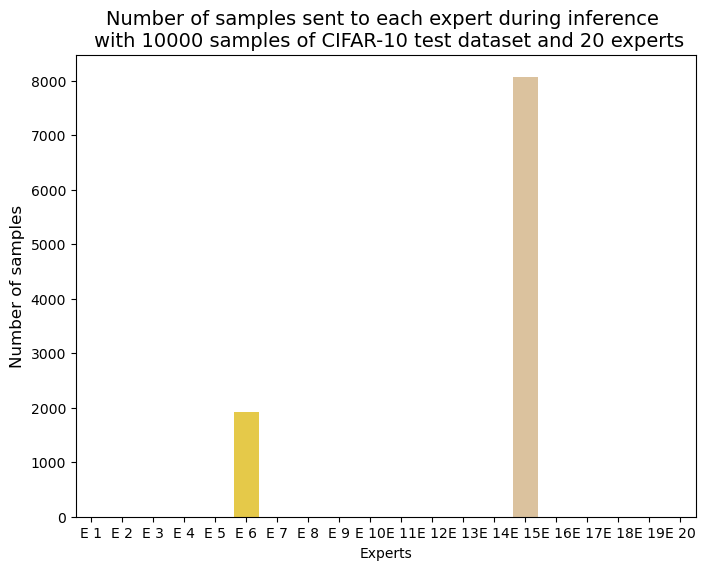

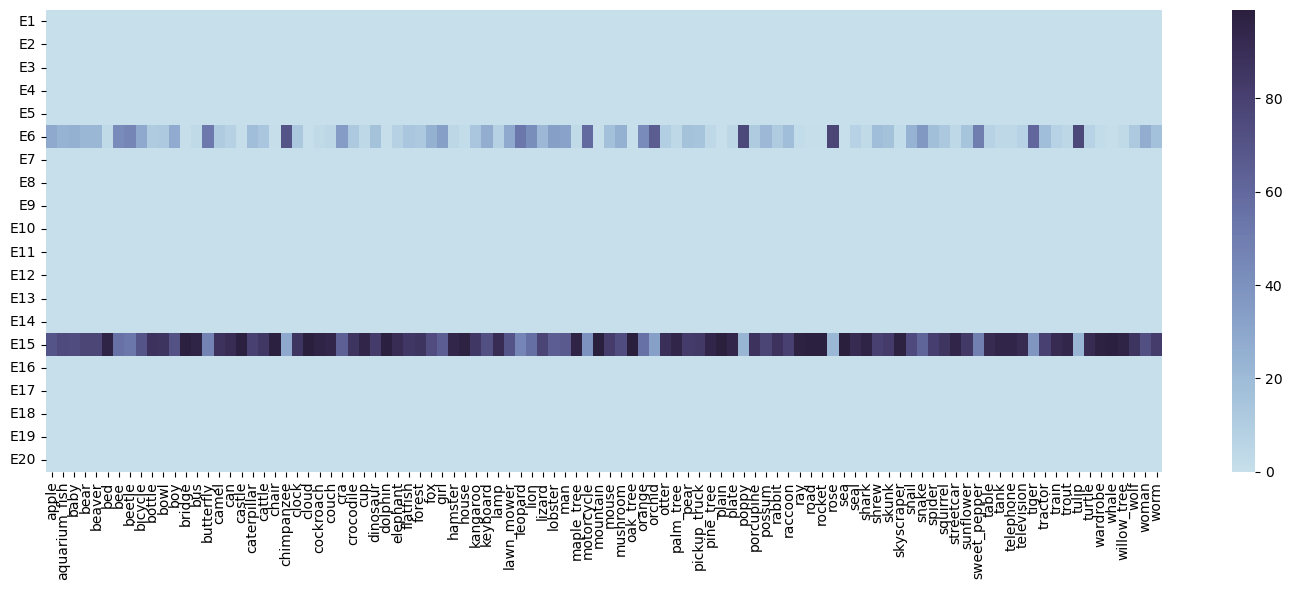

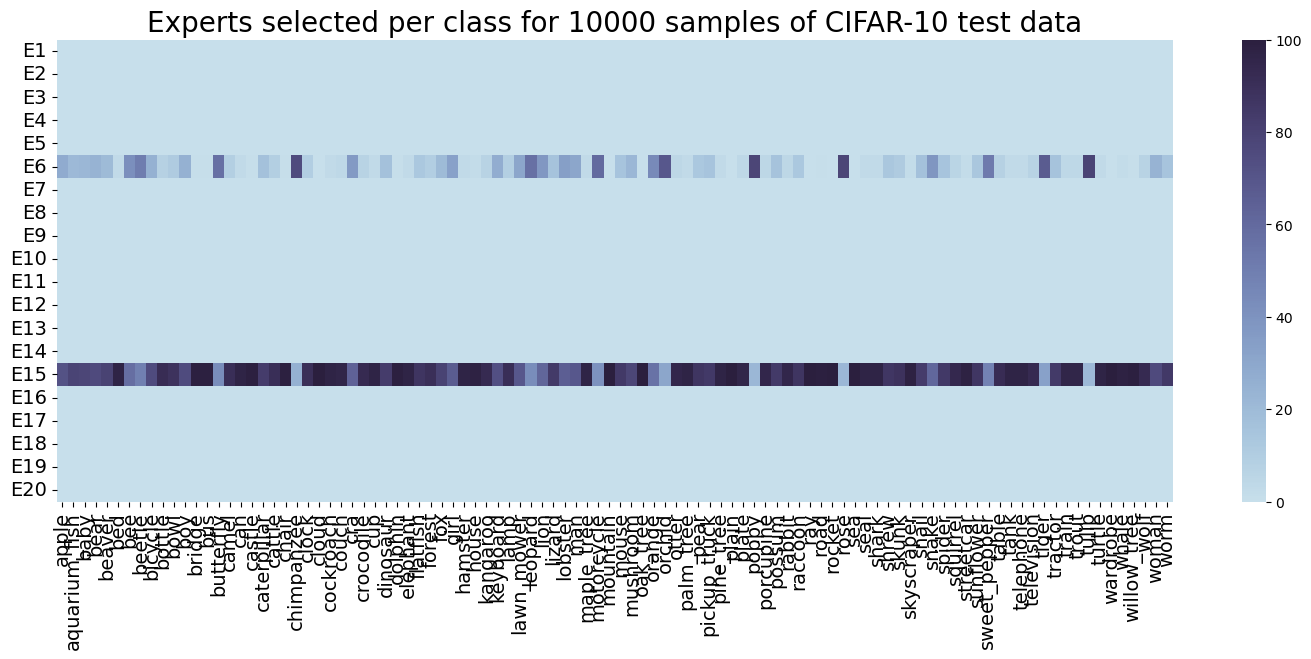

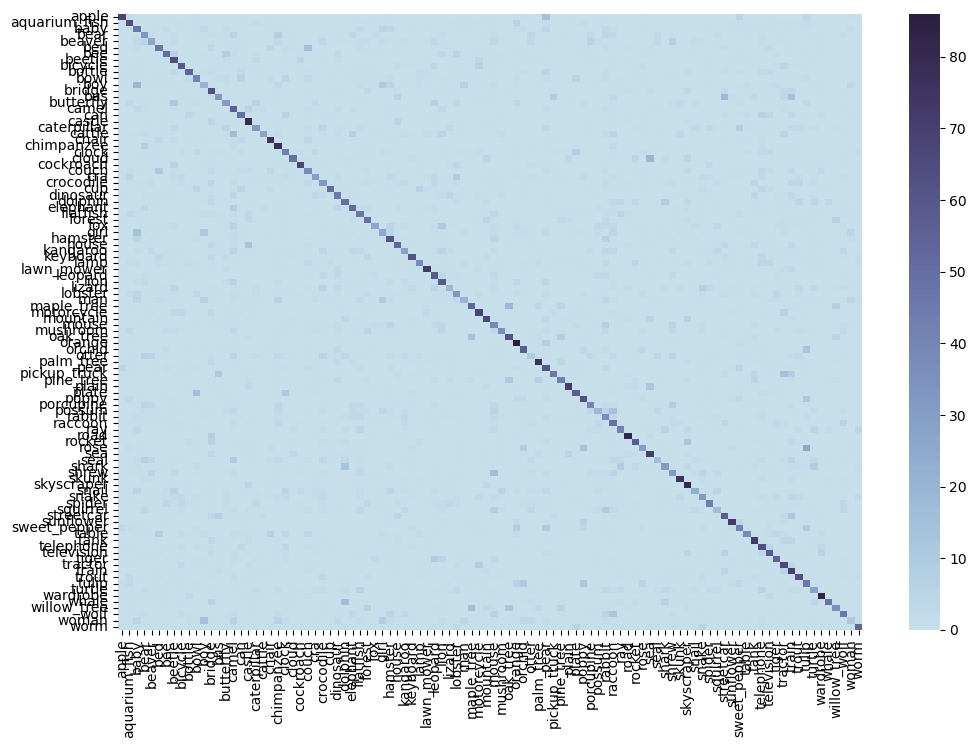

In [22]:
m = 'cifar100_rand_init_top_2'
total_experts = 20
classes = classes_cifar100
num_epochs = 50
temps = [[1.0]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, 'moe_top_k_model', test_loader=test_loader, temps=temps,
                  w_importance_range=w_importance_range, 
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, 
                  dataset='CIFAR-10', best=False, index=-1, annot=False, device=device)

Num  models 2
cifar100_rand_init_100_20_models.pt


<Figure size 640x480 with 0 Axes>

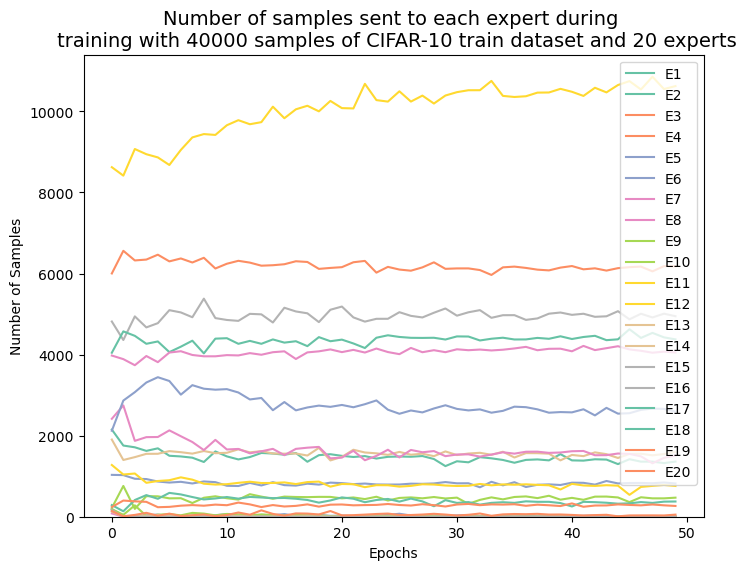

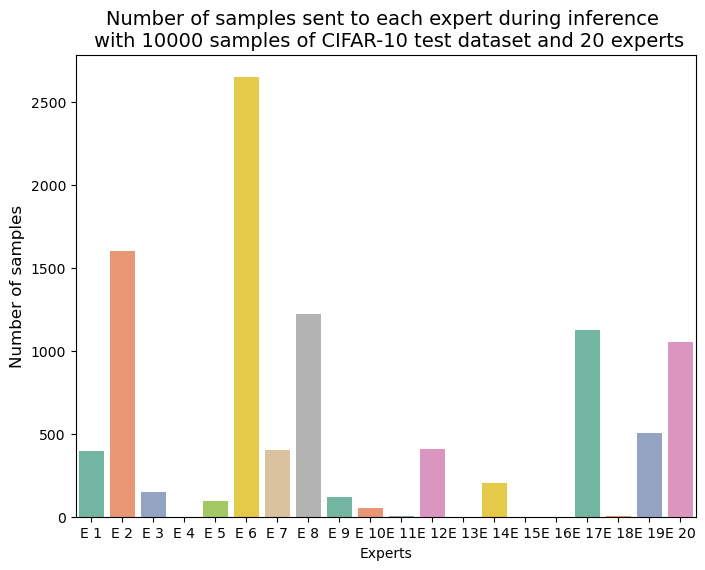

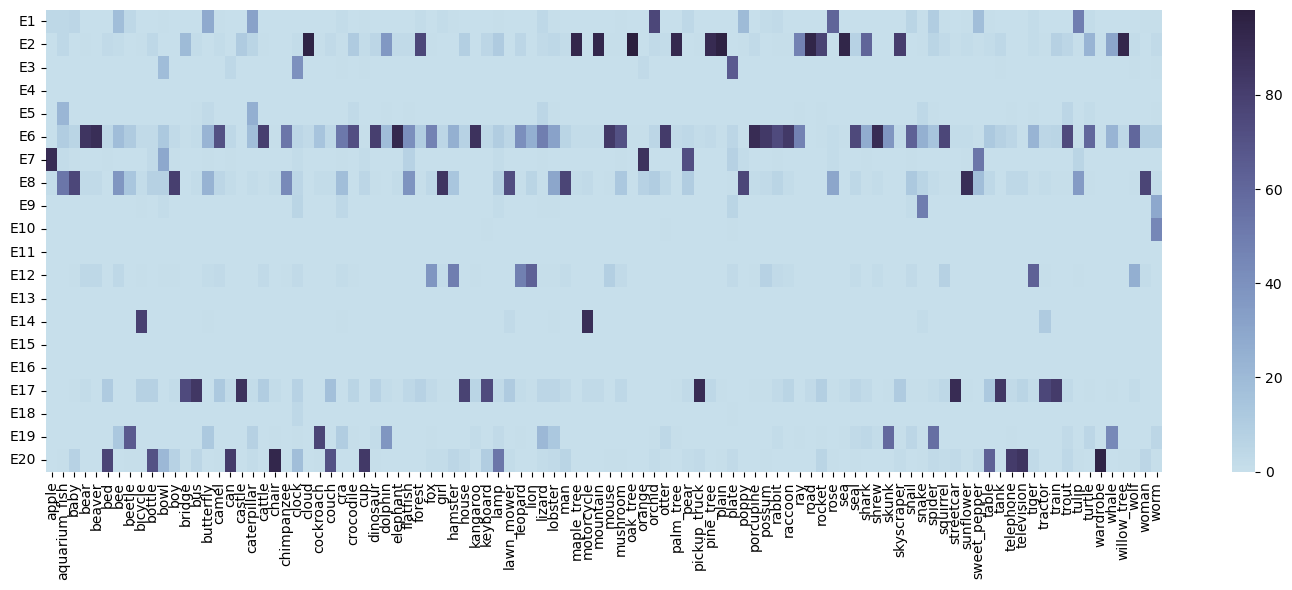

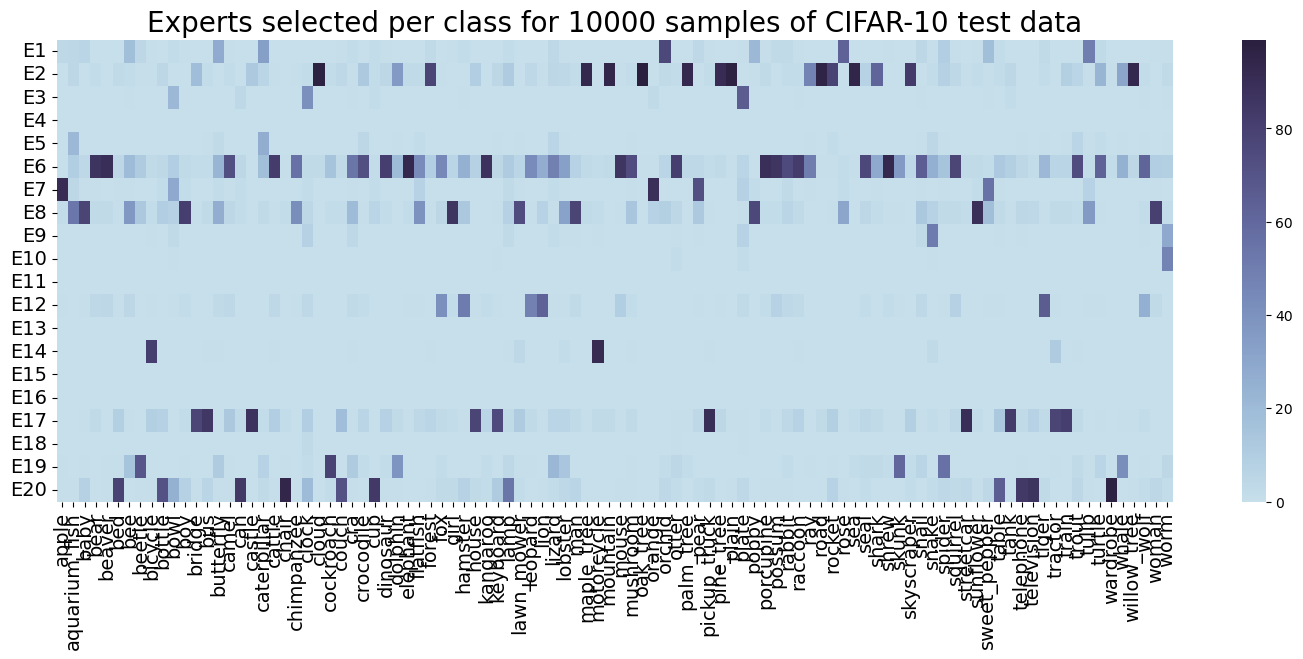

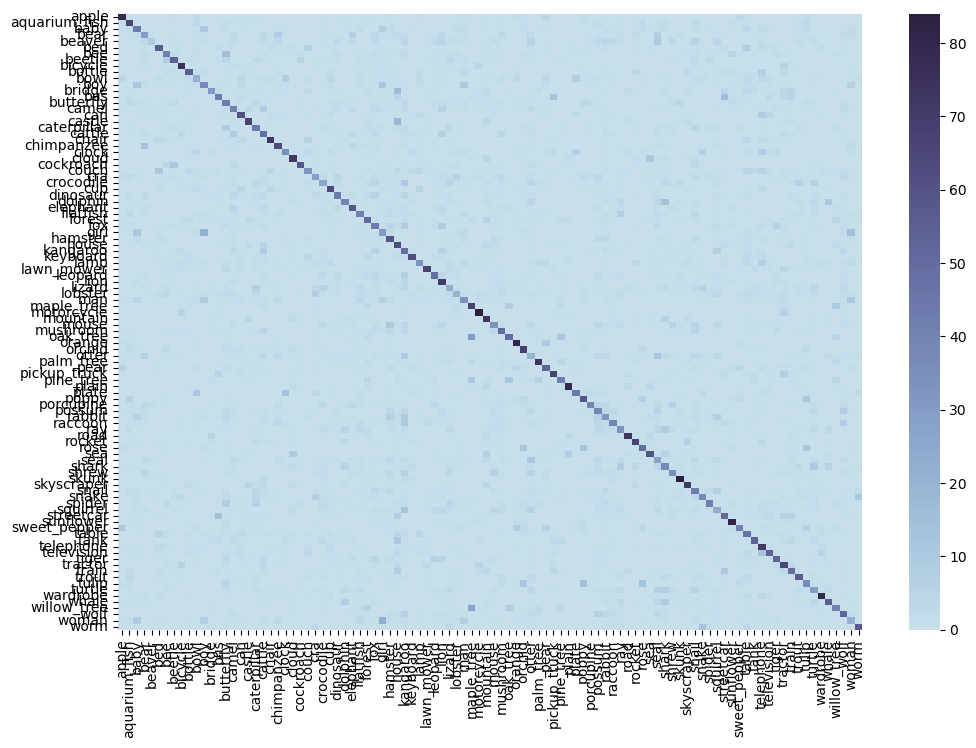

In [23]:
m = 'cifar100_rand_init'
total_experts = 20
classes = classes_cifar100
num_epochs = 50
temps = [[1.0]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, 'moe_stochastic_model', test_loader=test_loader, temps=temps,
                  w_importance_range=w_importance_range, 
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, 
                  dataset='CIFAR-10', best=False, index=-1, annot=False, device=device)

Train Accuracy 0.110
Max Validation Accuracy 0.508
Min Validation Error 0.492
Mutual Information 4.290
Sample Entropy 0.062
Expert Usage 4.294
Best model index 1
new_cifar100_no_gate_self_information_100_20_models.pt


<Figure size 640x480 with 0 Axes>

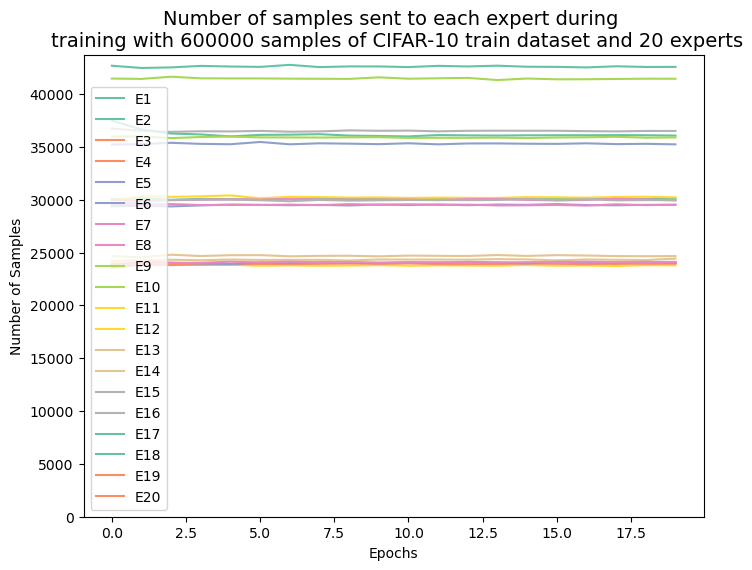

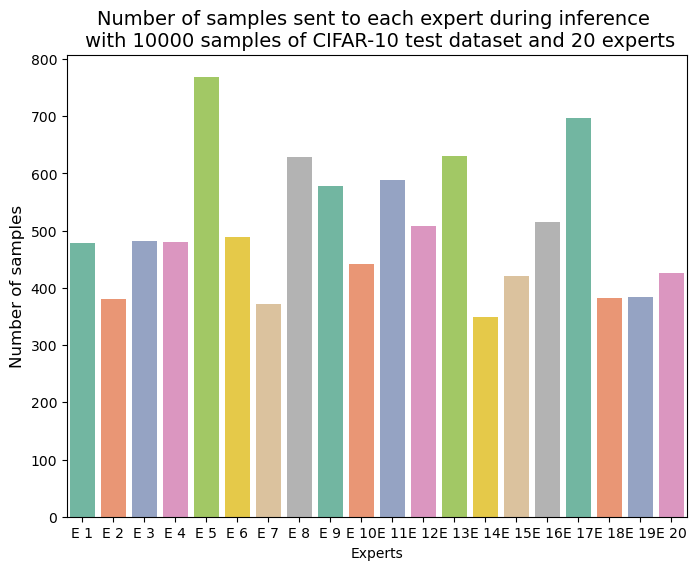

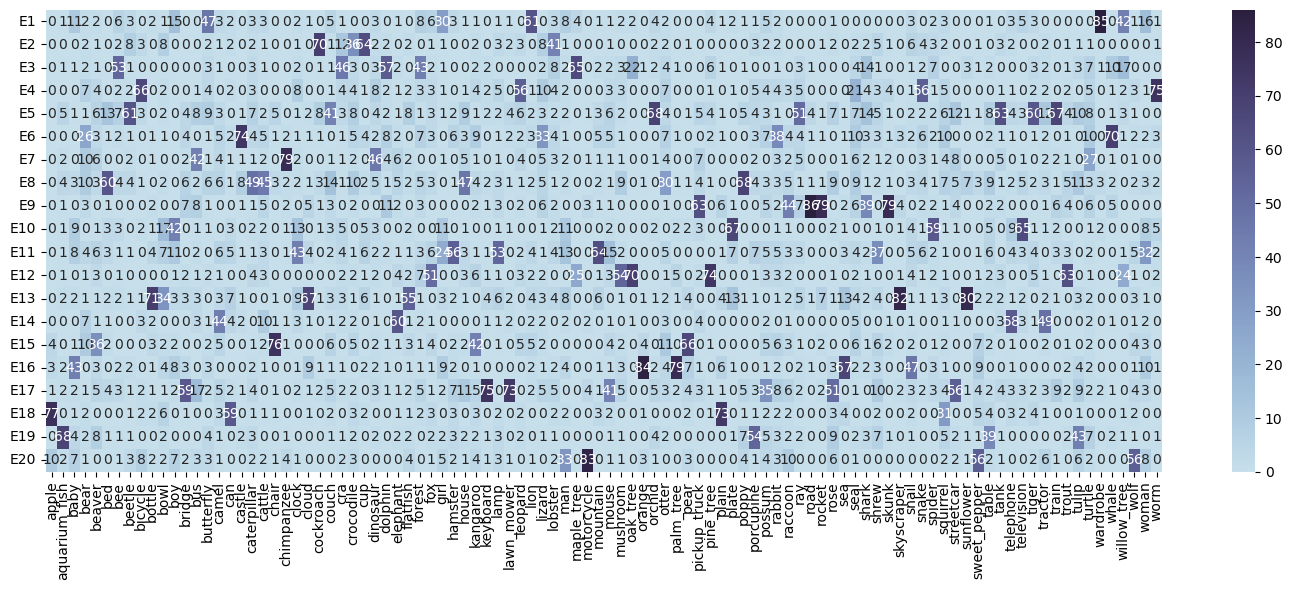

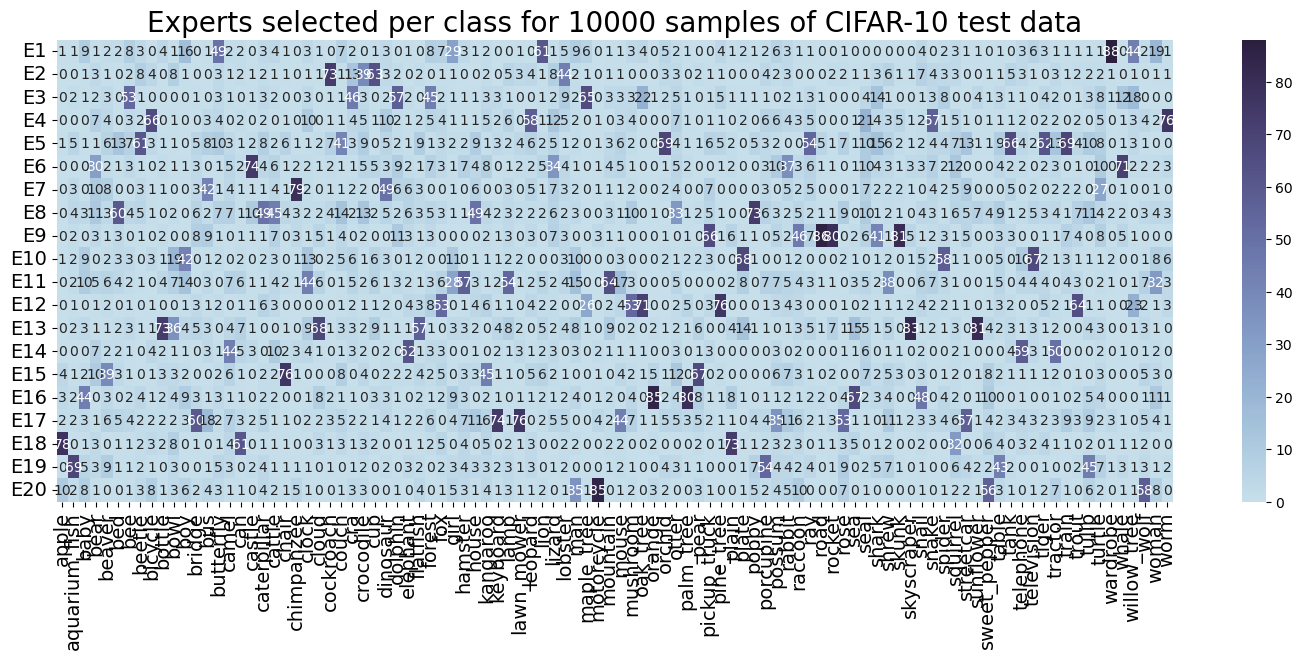

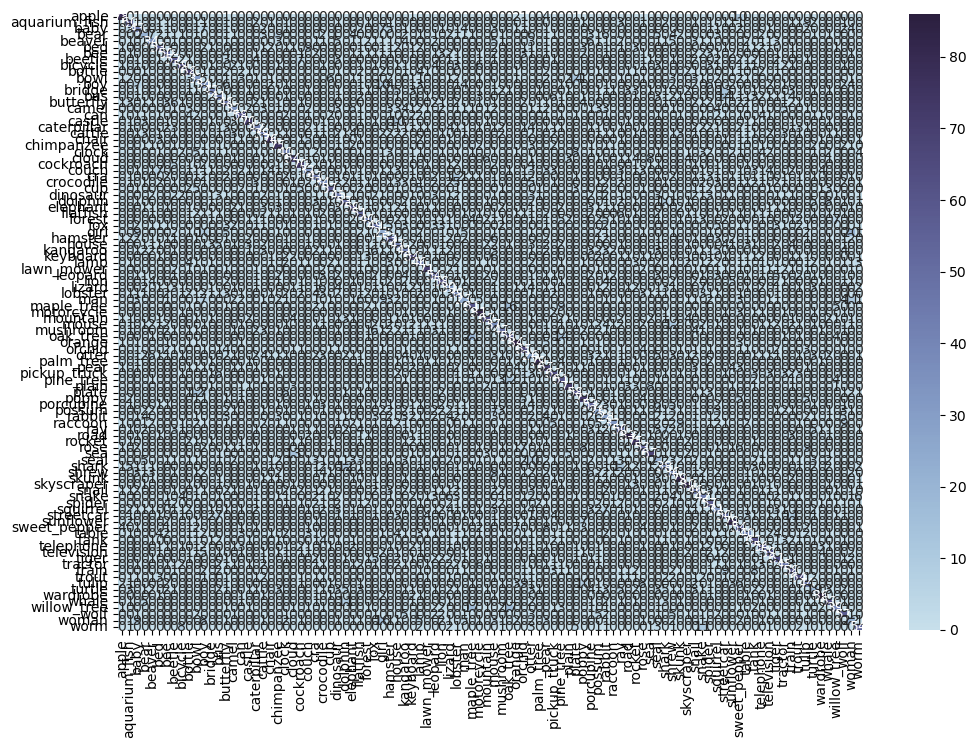

In [17]:
m = "new_cifar100_no_gate_self_information"
total_experts = 20
classes = classes_cifar100
num_epochs = 20
temps = [[1.0]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, 'moe_stochastic_model', test_loader=test_loader, temps=temps,
                  w_importance_range=w_importance_range, 
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, 
                  dataset='CIFAR-10',  device=device)

Train Accuracy 0.398
Max Validation Accuracy 0.461
Min Validation Error 0.539
Mutual Information 0.000
Sample Entropy 0.000
Expert Usage 0.000
Best model index 0
new_cifar100_no_gate_self_information_top_2_100_20_models.pt


<Figure size 640x480 with 0 Axes>

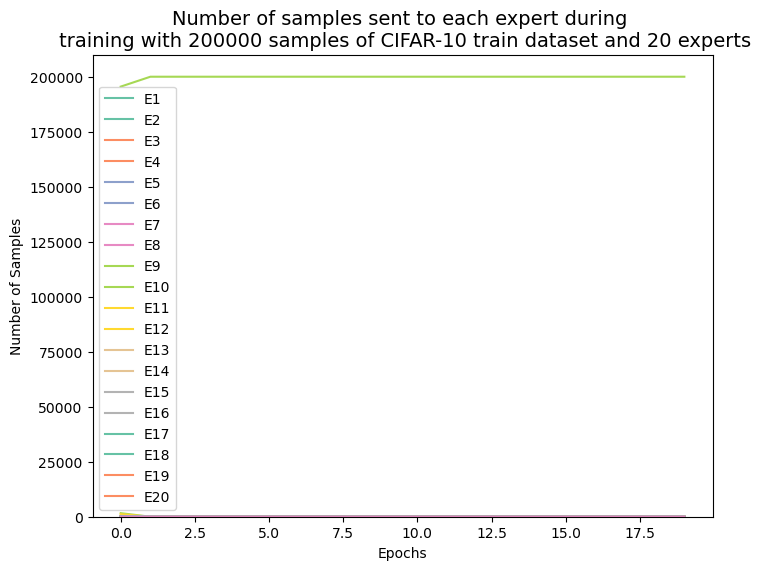

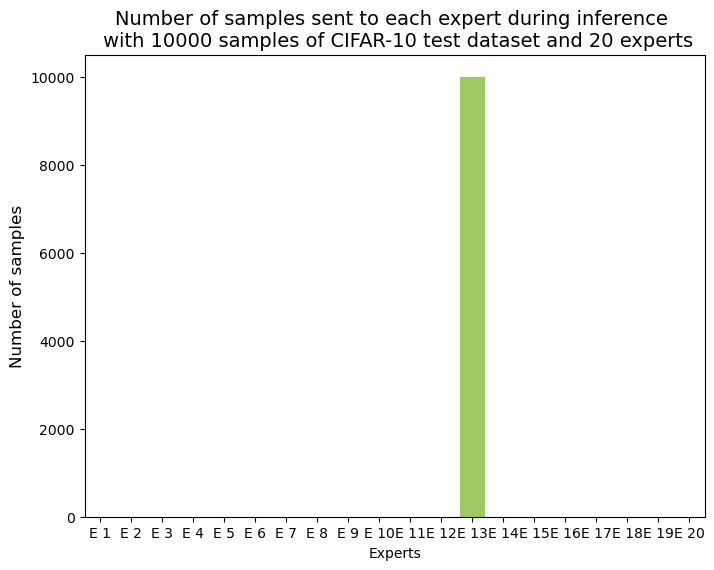

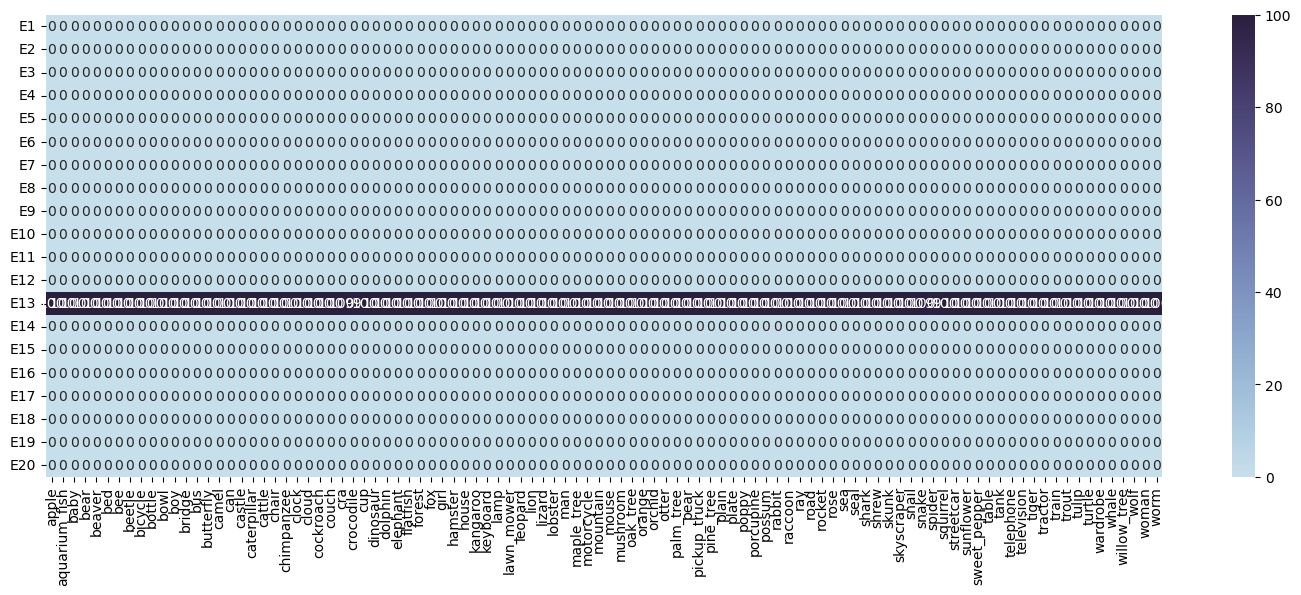

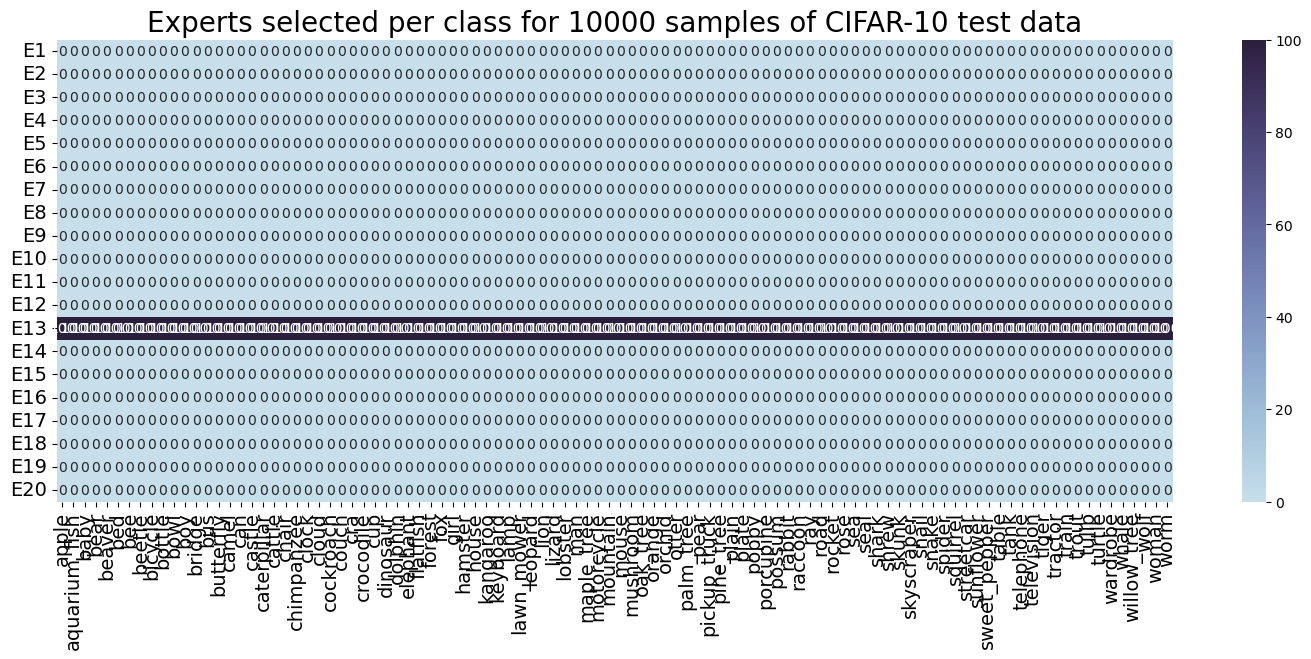

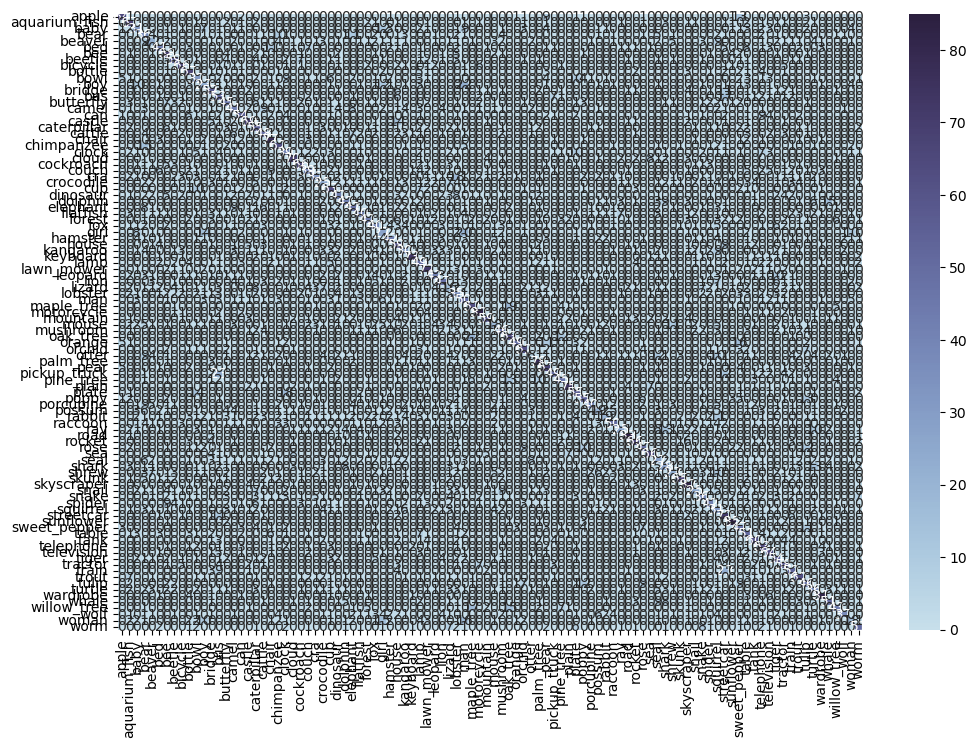

In [19]:

m = 'new_cifar100_no_gate_self_information_top_2'
total_experts = 20
classes = classes_cifar100
num_epochs = 20
temps = [[1.0]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, 'moe_top_k_model', test_loader=test_loader, temps=temps,
                  w_importance_range=w_importance_range, 
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, 
                  dataset='CIFAR-10',  device=device)


Train Accuracy 0.105
Max Validation Accuracy 0.821
Min Validation Error 0.179
Mutual Information 4.287
Sample Entropy 0.007
Expert Usage 4.295
Best model index 0
cifar100_no_gate_self_information_100_20_models.pt


<Figure size 640x480 with 0 Axes>

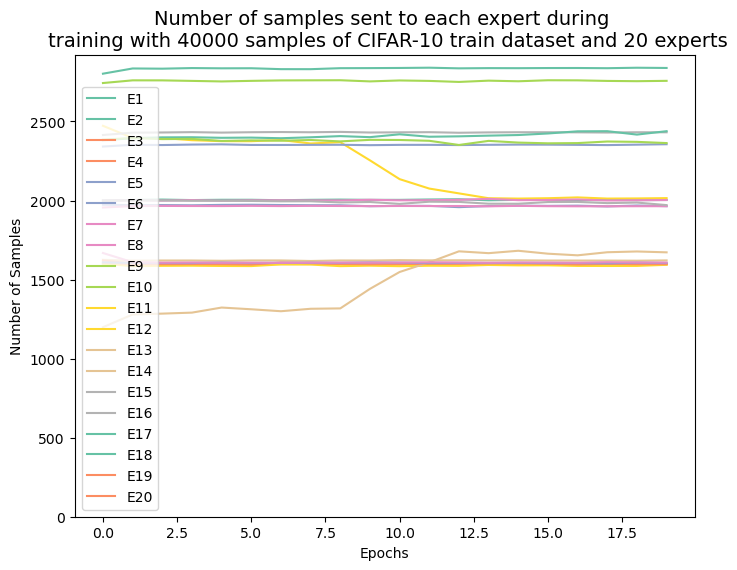

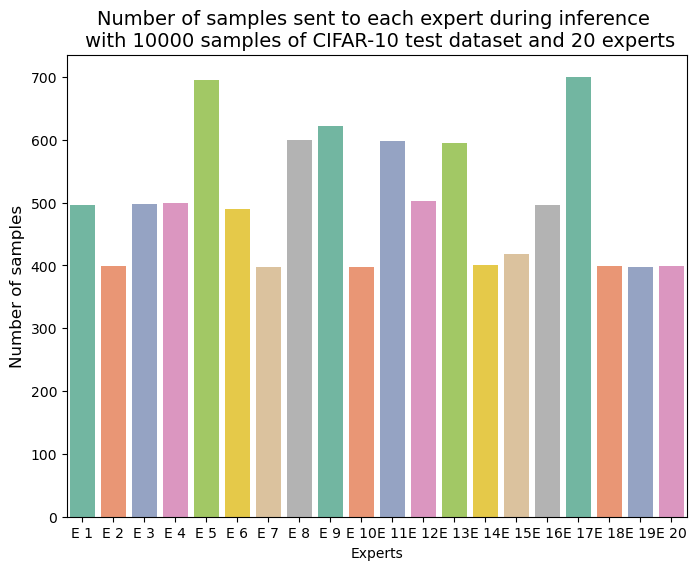

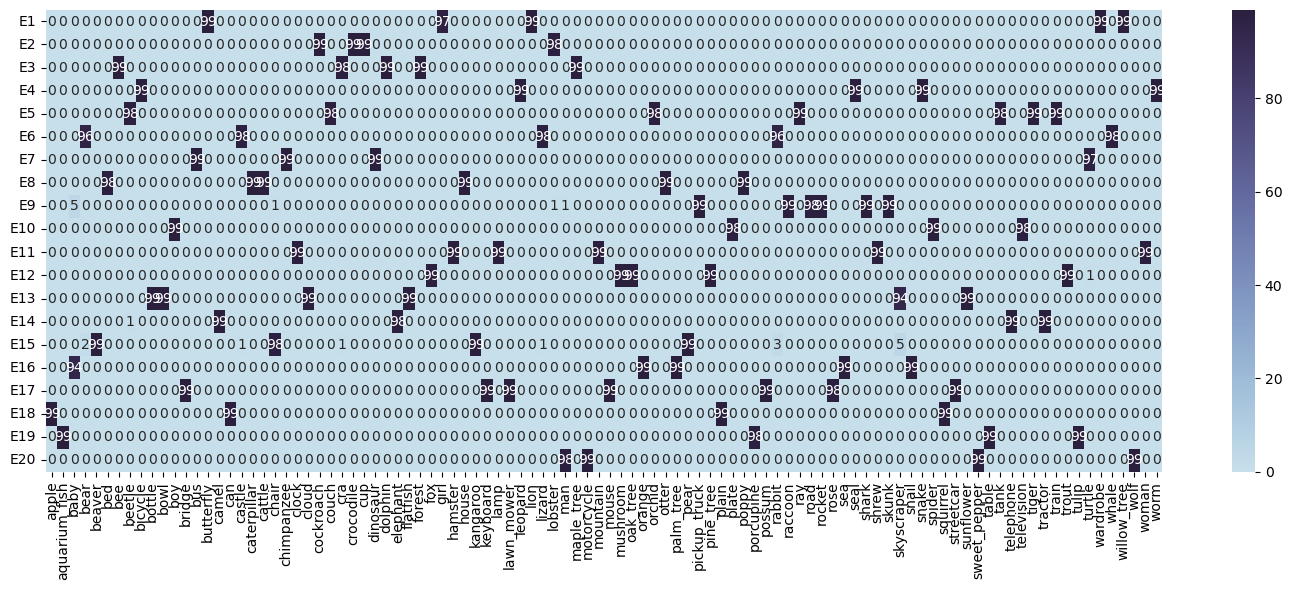

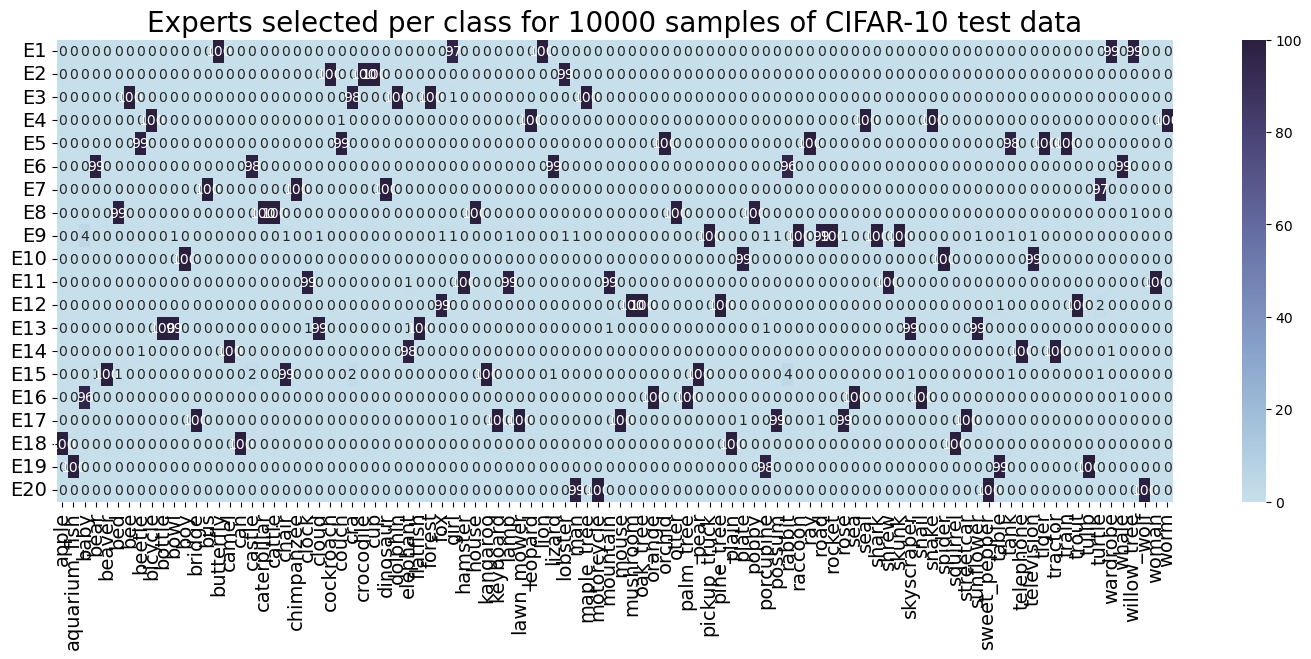

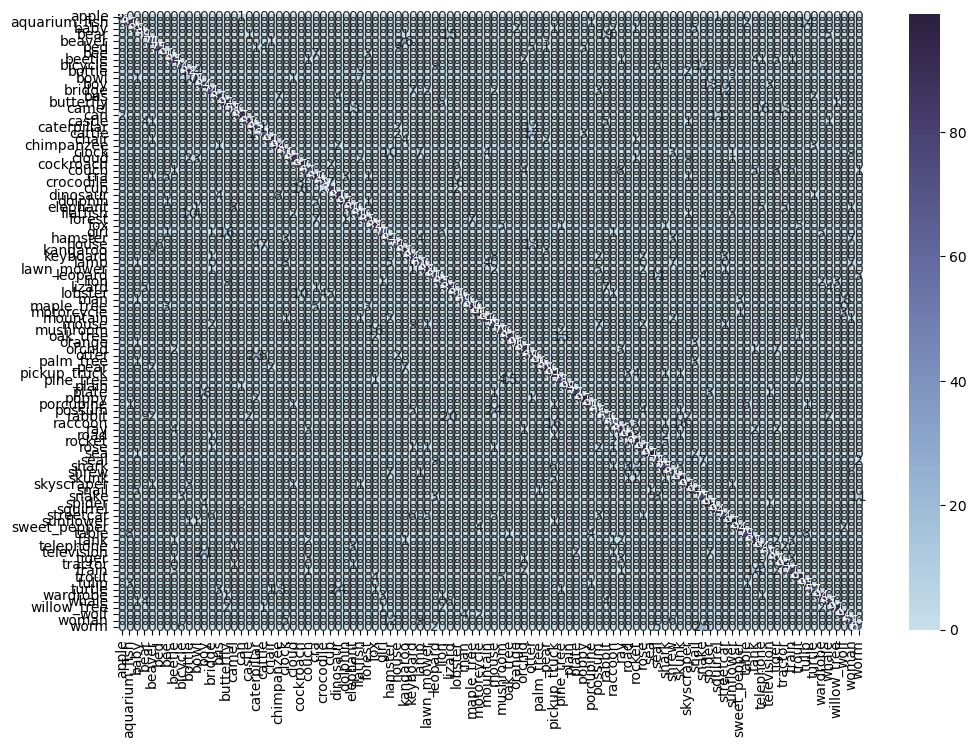

In [16]:
m = 'cifar100_no_gate_self_information'
total_experts = 20
classes = classes_cifar100
num_epochs = 20
temps = [[1.0]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, 'moe_no_gate_self_information_model', test_loader=test_loader, temps=temps,
                  w_importance_range=w_importance_range, 
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, 
                  dataset='CIFAR-10',  device=device)


Train Accuracy 0.008
Max Validation Accuracy 0.555
Min Validation Error 0.445
Mutual Information 0.424
Sample Entropy 0.063
Expert Usage 1.307
Best model index 0
cifar100_stochastic_test_100_10_models.pt


<Figure size 640x480 with 0 Axes>

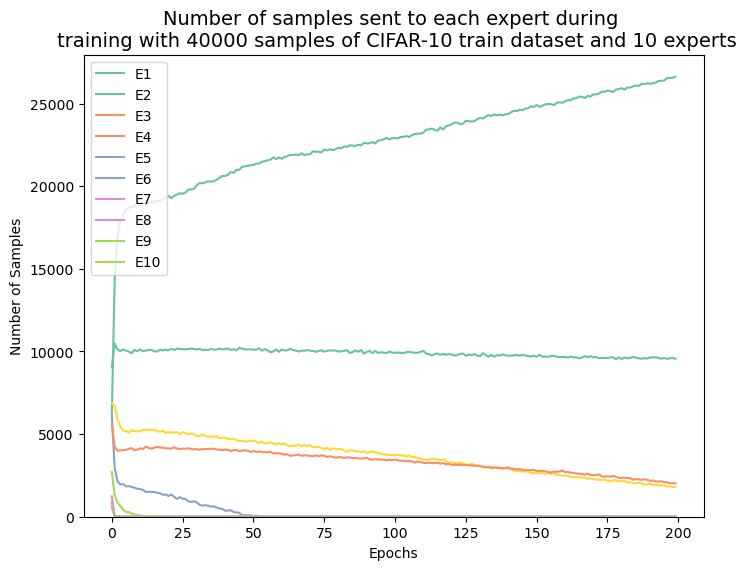

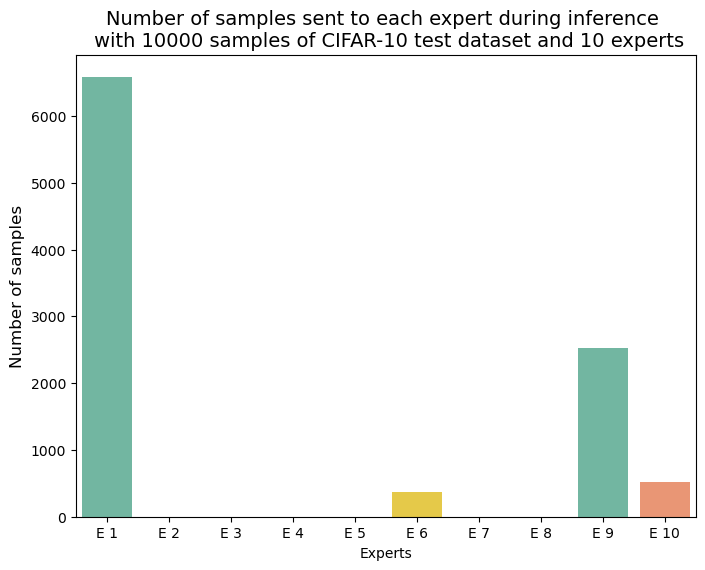

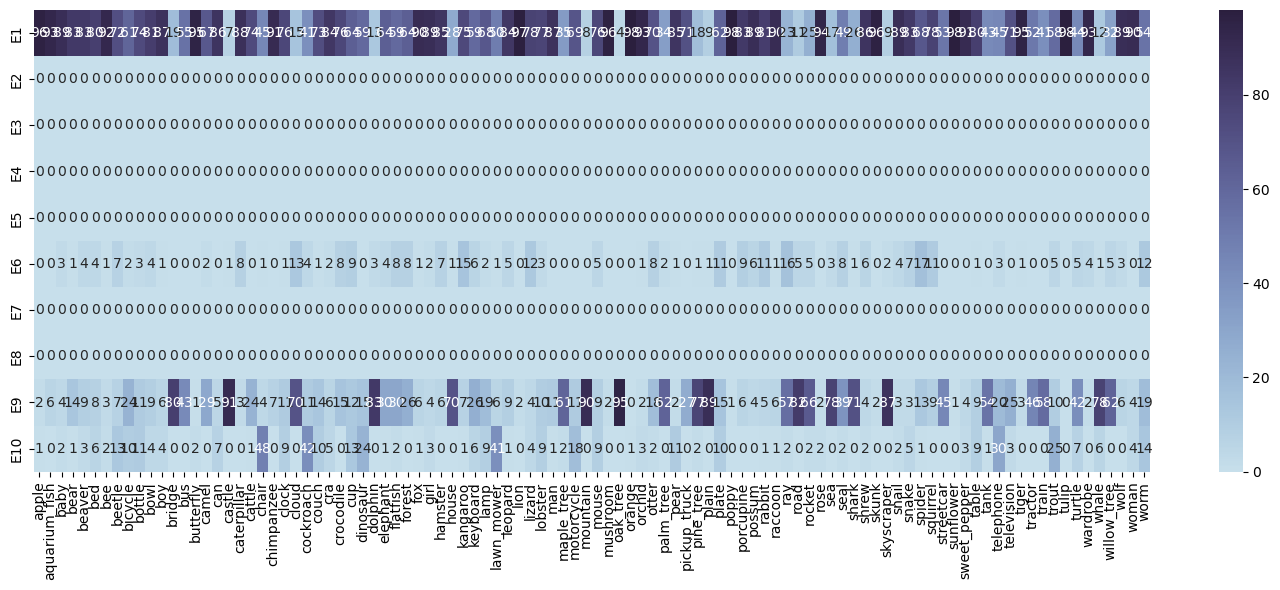

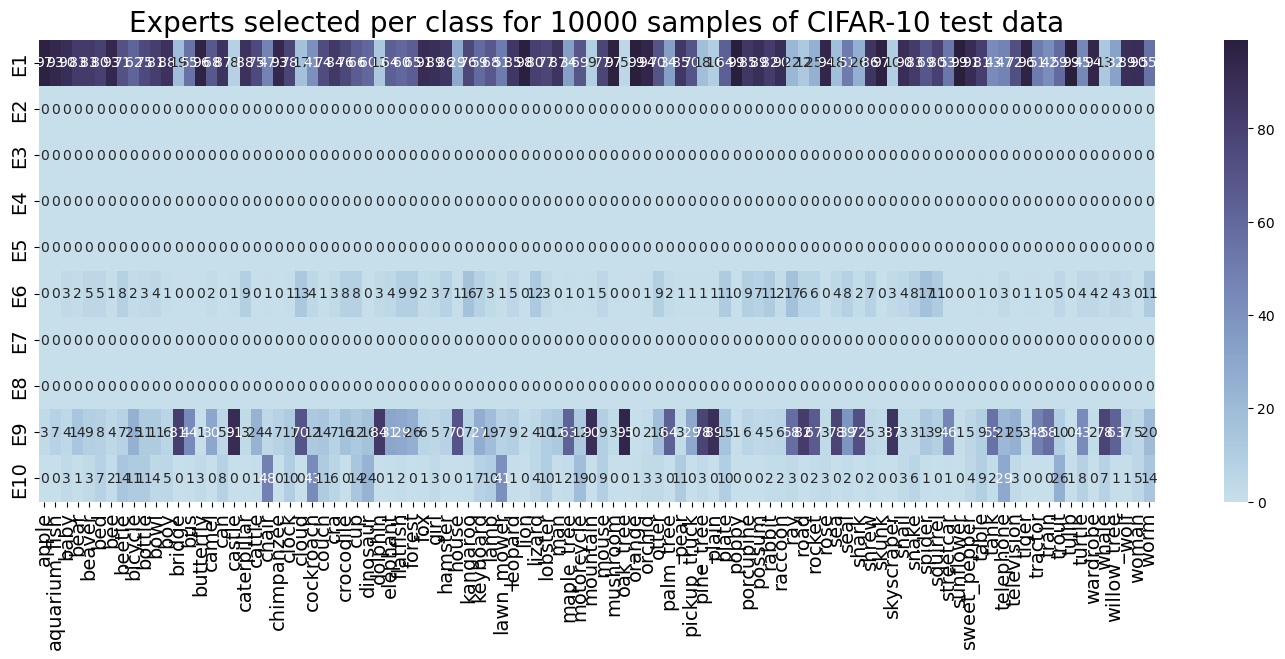

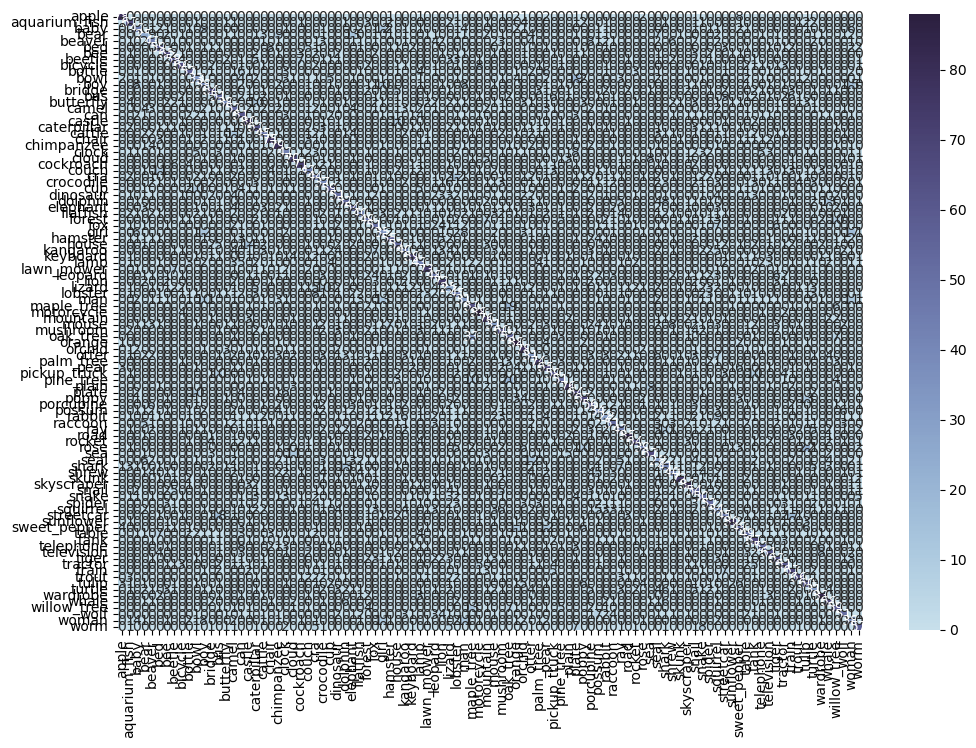

In [23]:
m = 'cifar100_stochastic_test'
total_experts = 10
classes = classes_cifar100
num_epochs = 200
temps = [[1.0]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, 'moe_stochastic_model', test_loader=test_loader, temps=temps,
                  w_importance_range=w_importance_range, 
                  total_experts=total_experts,num_classes=num_classes,
                  classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, 
                  dataset='CIFAR-10',  device=device)


In [41]:
pre_trained_model_path = '../models/hidden_128'

In [42]:
import sys
sys.path.append('../src')

In [30]:
# Compute accuracy of the model
def accuracy_top5(out, yb):
    preds = torch.argsort(out, dim=1,descending=True).to(device, non_blocking=True)
    N = preds.shape[0]
    correct = 0
    for i in range(N):
        # print(yb[i], preds[i,0:5], out[i, preds[i,0:5]])
        # print(out[i, preds[i,:]])
        if yb[i] in preds[i,0:5]:
            correct += 1
    return correct/N
    

In [31]:
import csv

m = 'cifar100_single_model'
plot_file = generate_plot_file(m, specific=str(num_classes)+'_models.pt')
models = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
filename = os.path.join(results_path, 'cifar100_results_hidden_128.csv')
if os.path.exists(filename):
    p = 'a'
else:
    p = 'w'
        
header = ['filename', 'train error', 'top-1 error', 'top-5 error', 'mutual information', 'sample entropy', 'experts usage']
    
with open(filename, p) as f:
    writer = csv.writer(f)        

    if p == 'w':            
        writer.writerow(header)
    for i, model in enumerate(models['models']):
        data = ['']*5
        data[0] = m+'_'+str(i)
        running_top1_accuracy = 0.0
        running_top5_accuracy = 0.0
        num_batches = 0
        train_error = 1-models['history'][i]['accuracy'][-1]
        data[1] = train_error
        for test_inputs, test_labels in cifar100_testloader:
            test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
            outputs = model(test_inputs)
            running_top1_accuracy += accuracy(outputs, test_labels)
            running_top5_accuracy += accuracy_top5(outputs, test_labels)
            num_batches += 1
        top1_error = 1-(running_top1_accuracy/num_batches)
        top5_error = 1-(running_top5_accuracy/num_batches)
        data[2] = top1_error.item()
        data[3] = top5_error
        
        writer.writerow(data)


torch.Size([10000])


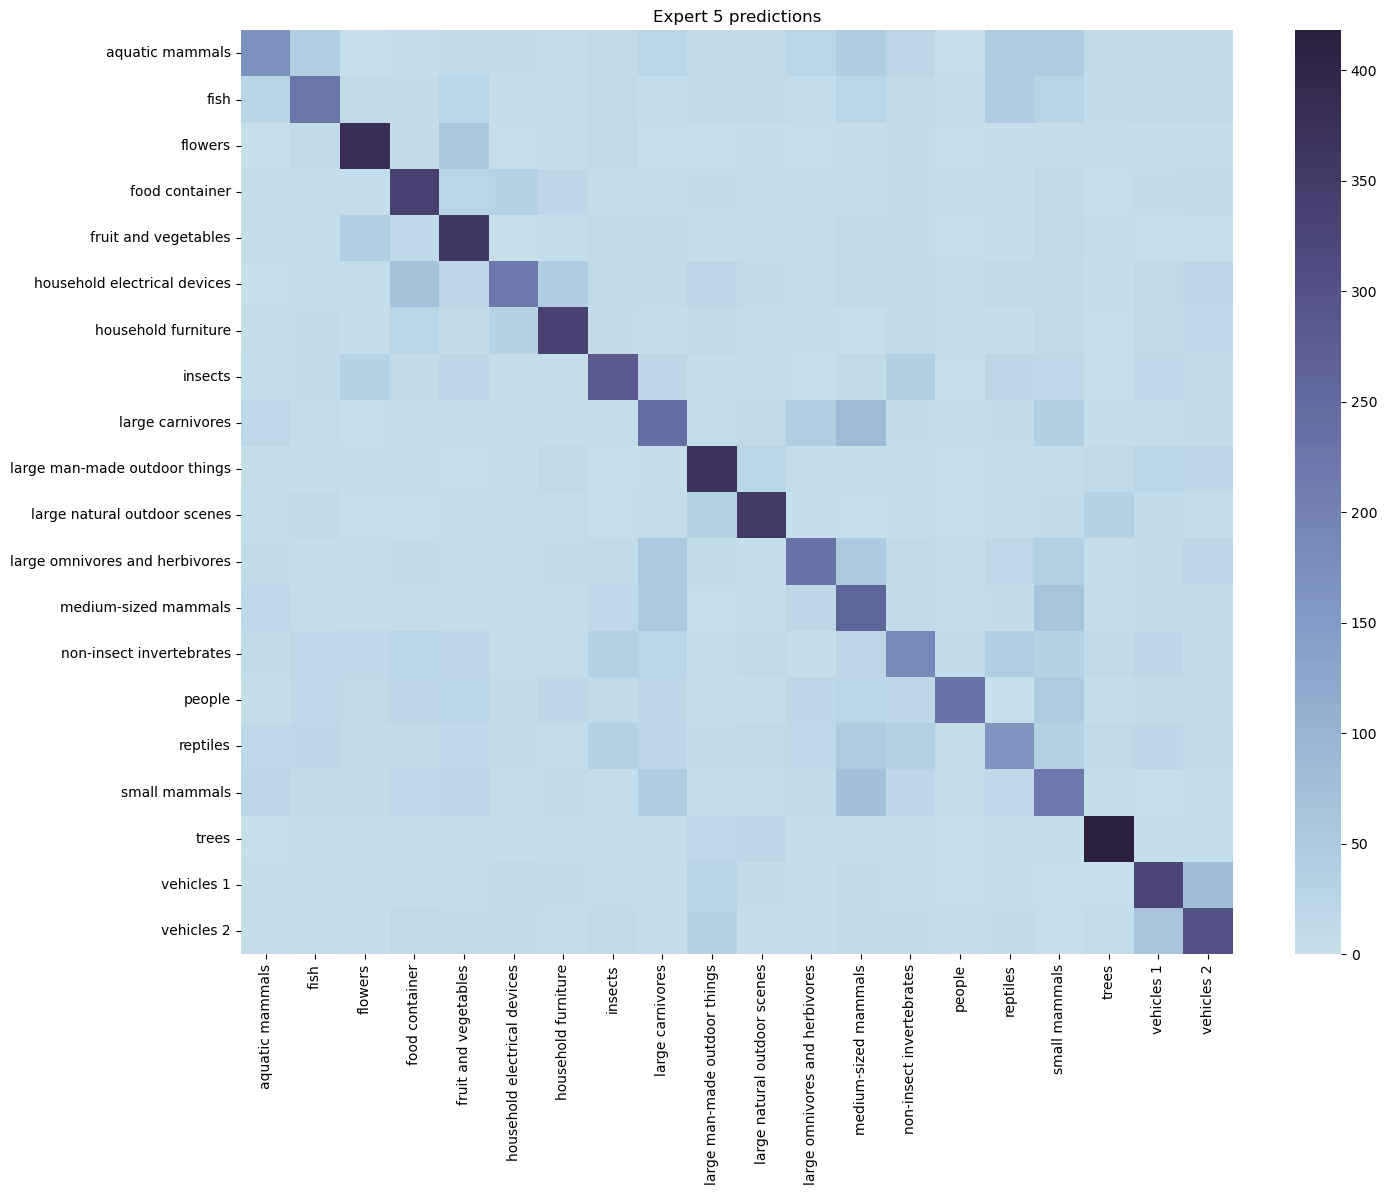

In [76]:
m = 'cifar100_single_model'

plot_file = generate_plot_file(m, specific=str(num_classes)+'_models.pt')
models = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
min_train_error = float('inf')
best_model = models['models'][0]
for i, model in enumerate(models['models']):
    train_error = 1-models['history'][i]['accuracy'][-1]
    if train_error < min_train_error:
        min_train_error = train_error
        best_model = model
true_labels = []
pred_labels = []
for test_inputs, test_labels in cifar100_testloader:
    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
    outputs = model(test_inputs)
    true_labels += test_labels
    pred_labels += torch.argmax(outputs, dim=1)

true_labels = torch.stack(true_labels)
pred_labels = torch.stack(pred_labels)

print(true_labels.shape)

true_coarse_labels = []
pred_coarse_labels = []
for true_label, pred_label in zip(true_labels,pred_labels):
    coarse_label_name = reverse_coarse_labels_cifar100[classes_cifar100[true_label]]
    coarse_label = list(coarse_labels_cifar100.keys()).index(coarse_label_name)
    true_coarse_labels.append(coarse_label)
    
    coarse_label_name = reverse_coarse_labels_cifar100[classes_cifar100[pred_label]]
    coarse_label = list(coarse_labels_cifar100.keys()).index(coarse_label_name)
    pred_coarse_labels.append(coarse_label)

fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(16, 12))
conf_mat = confusion_matrix(true_coarse_labels, pred_coarse_labels)
sns.heatmap(conf_mat, 
            xticklabels=[list(coarse_labels_cifar100.keys())[i] for i in range(0, 20)],
            yticklabels=[list(coarse_labels_cifar100.keys())[i] for i in range(0, 20)], 
            cmap=cmap, ax=ax)
plt.title('Expert %d predictions'%(i+1))
plt.savefig(os.path.join(fig_path, 'single_model_conf_tab.png'))
plt.show()


In [64]:
correct = [conf_mat[i,i] for i in range(num_classes)]
correct_sorted = torch.argsort(torch.tensor(correct))
print('\u001b[1m Best and worst classified \u001b[0m')
print([(classes_cifar100[c], correct[c]) for c in correct_sorted])

classification = torch.argsort(torch.tensor(conf_mat), dim=1, descending=True)

print('\u001b[1m Common misclassifications for each class \u001b[0m')
for i in range(num_classes):
    print('Actual class:', classes_cifar100[i])
    row = conf_mat[i,:]
    print([(classes_cifar100[c], row[c].item()) for c in classification[i,:] if row[c].item() >= 5 ],'\n')
    

 Best and worst classified 
[('otter', 5), ('girl', 8), ('bear', 11), ('snake', 14), ('seal', 14), ('kangaroo', 14), ('tulip', 18), ('beaver', 19), ('snail', 19), ('possum', 19), ('butterfly', 20), ('boy', 22), ('clock', 22), ('ray', 22), ('rabbit', 22), ('lobster', 22), ('bed', 22), ('baby', 22), ('lamp', 23), ('man', 23), ('crocodile', 23), ('woman', 24), ('mouse', 24), ('shrew', 25), ('lizard', 26), ('squirrel', 27), ('wolf', 27), ('couch', 28), ('table', 28), ('bowl', 29), ('pine_tree', 29), ('flatfish', 30), ('camel', 30), ('crab', 30), ('dolphin', 32), ('bus', 32), ('caterpillar', 34), ('shark', 34), ('dinosaur', 35), ('cattle', 36), ('turtle', 36), ('train', 36), ('raccoon', 36), ('spider', 38), ('bridge', 38), ('elephant', 39), ('sweet_pepper', 39), ('telephone', 40), ('whale', 40), ('worm', 40), ('tiger', 41), ('rose', 41), ('aquarium_fish', 42), ('pickup_truck', 42), ('hamster', 43), ('willow_tree', 43), ('keyboard', 43), ('leopard', 43), ('porcupine', 43), ('can', 45), ('mou